# Endothelial Cells

In [83]:
# external dependencies
import os
import sys
notebook_path = os.path.abspath('.')
sources_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, sources_path)
# import custom modules
import utils
import models
import dataloaders

# basic imports
import json
import pprint
import pickle
import logging
from tqdm.auto import tqdm, trange

# scientific python
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import describe as describe_stats
#from scipy.stats import mannwhitneyu
from scipy.special import logit
RAND_SEED = 28
np.random.seed(RAND_SEED)

# Scanpy modules
import scanpy as sc
import anndata

logger = logging.getLogger()
utils.matplotlib_settings()
utils.print_module_versions([sc, anndata])

from sklearn.cluster import KMeans

scanpy    : 1.8.1
anndata   : 0.7.6


## Load the data

In [2]:
# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [3]:
PREFIX = 'Mike'
CELLTYPE = 'endothelial_stalk'
dirname = f'latent_space_structure/data/{PREFIX}_{CELLTYPE}/all_endo/'

#output_path = f'../data/{PREFIX}_{CELLTYPE}/'
#if not os.path.exists(output_path):
#    os.mkdir(output_path)

### (NB: only need to run this the first time) Load all Endothelial from CSV files and save in adata 

In [4]:
counts = pd.read_csv(f"{dirname}/all_endo_counts_allgenes.csv")

barcodes = counts.index.values
counts.reset_index(inplace=True, drop=True)
counts['barcode'] = barcodes
barcodes = [str(item) for item in counts.barcode.values]
counts = counts.set_index("barcode")

gene_names = np.asarray(counts.columns.values)
expression_gn = counts.values.T

adata = sc.AnnData(expression_gn.T)
adata.var_names = anndata.utils.make_index_unique(pd.Index(gene_names))
adata.var['gene_ids'] = gene_names
adata.obs['barcodes'] = pd.Index(barcodes, name=0)
adata.raw = adata

# filter beads 
sc.pp.filter_cells(adata, min_genes=20, inplace=True)
# filter genes
sc.pp.filter_genes(adata, min_cells=1, inplace=True)
mito_genes = adata.var_names.str.startswith('mt-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['n_counts'] = adata.X.sum(axis=1)

# add metadata
labels = pd.read_csv(f'{dirname}/all_endo_condition.csv')['x'].values
animal_id = pd.read_csv(f'{dirname}/all_endo_animal_id.csv')['x'].values
timepoint = pd.read_csv(f'{dirname}/all_endo_timepoint.csv')['x'].values
cluster = pd.read_csv(f'{dirname}/all_endo_clusters.csv')['x'].values
adata.obs['status'] = labels
adata.obs['animal_id'] = animal_id
adata.obs['timepoint'] = timepoint
adata.obs['cluster'] = cluster

adata.obs['status'] = adata.obs['status'].astype('category')
adata.obs['cluster'] = adata.obs['cluster'].astype('category')

# save the adata before manipulating
adata.write(os.path.join(dirname, 'adata.h5ad'))

adata

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'animal_id' as categorical
/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'timepoint' as categorical


AnnData object with n_obs × n_vars = 891 × 16868
    obs: 'barcodes', 'n_genes', 'percent_mito', 'n_counts', 'status', 'animal_id', 'timepoint', 'cluster'
    var: 'gene_ids', 'n_cells'

### Load the unmanipulated adata object for all endothelial cells.

(Optional) Subset the part of interest before normalizing etc.

In [5]:
# Load
adata = sc.read(os.path.join(dirname, 'adata.h5ad'))
adata

AnnData object with n_obs × n_vars = 891 × 16868
    obs: 'barcodes', 'n_genes', 'percent_mito', 'n_counts', 'status', 'animal_id', 'timepoint', 'cluster'
    var: 'gene_ids', 'n_cells'

In [6]:
# Subset
#adata = adata[adata.obs['timepoint'].isin(['7dpi'])]
#adata = adata[adata.obs['cluster'].isin([1])]
#adata = adata[adata.obs['status'].isin([0])]
#adata = adata[~adata.obs['animal_id'].isin(["M115"])]
subset_title_str = f'{CELLTYPE}'
adata

AnnData object with n_obs × n_vars = 891 × 16868
    obs: 'barcodes', 'n_genes', 'percent_mito', 'n_counts', 'status', 'animal_id', 'timepoint', 'cluster'
    var: 'gene_ids', 'n_cells'

In [7]:
# Preprocess
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
#
#sc.pp.highly_variable_genes(adata, min_mean=0.03, max_mean=5, min_disp=0.9) #min_mean=0.01, max_mean=4, min_disp=0.2
#adata = adata[:, adata.var.highly_variable]
#
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata)

adata

AnnData object with n_obs × n_vars = 891 × 16868
    obs: 'barcodes', 'n_genes', 'percent_mito', 'n_counts', 'status', 'animal_id', 'timepoint', 'cluster', 'leiden'
    var: 'gene_ids', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

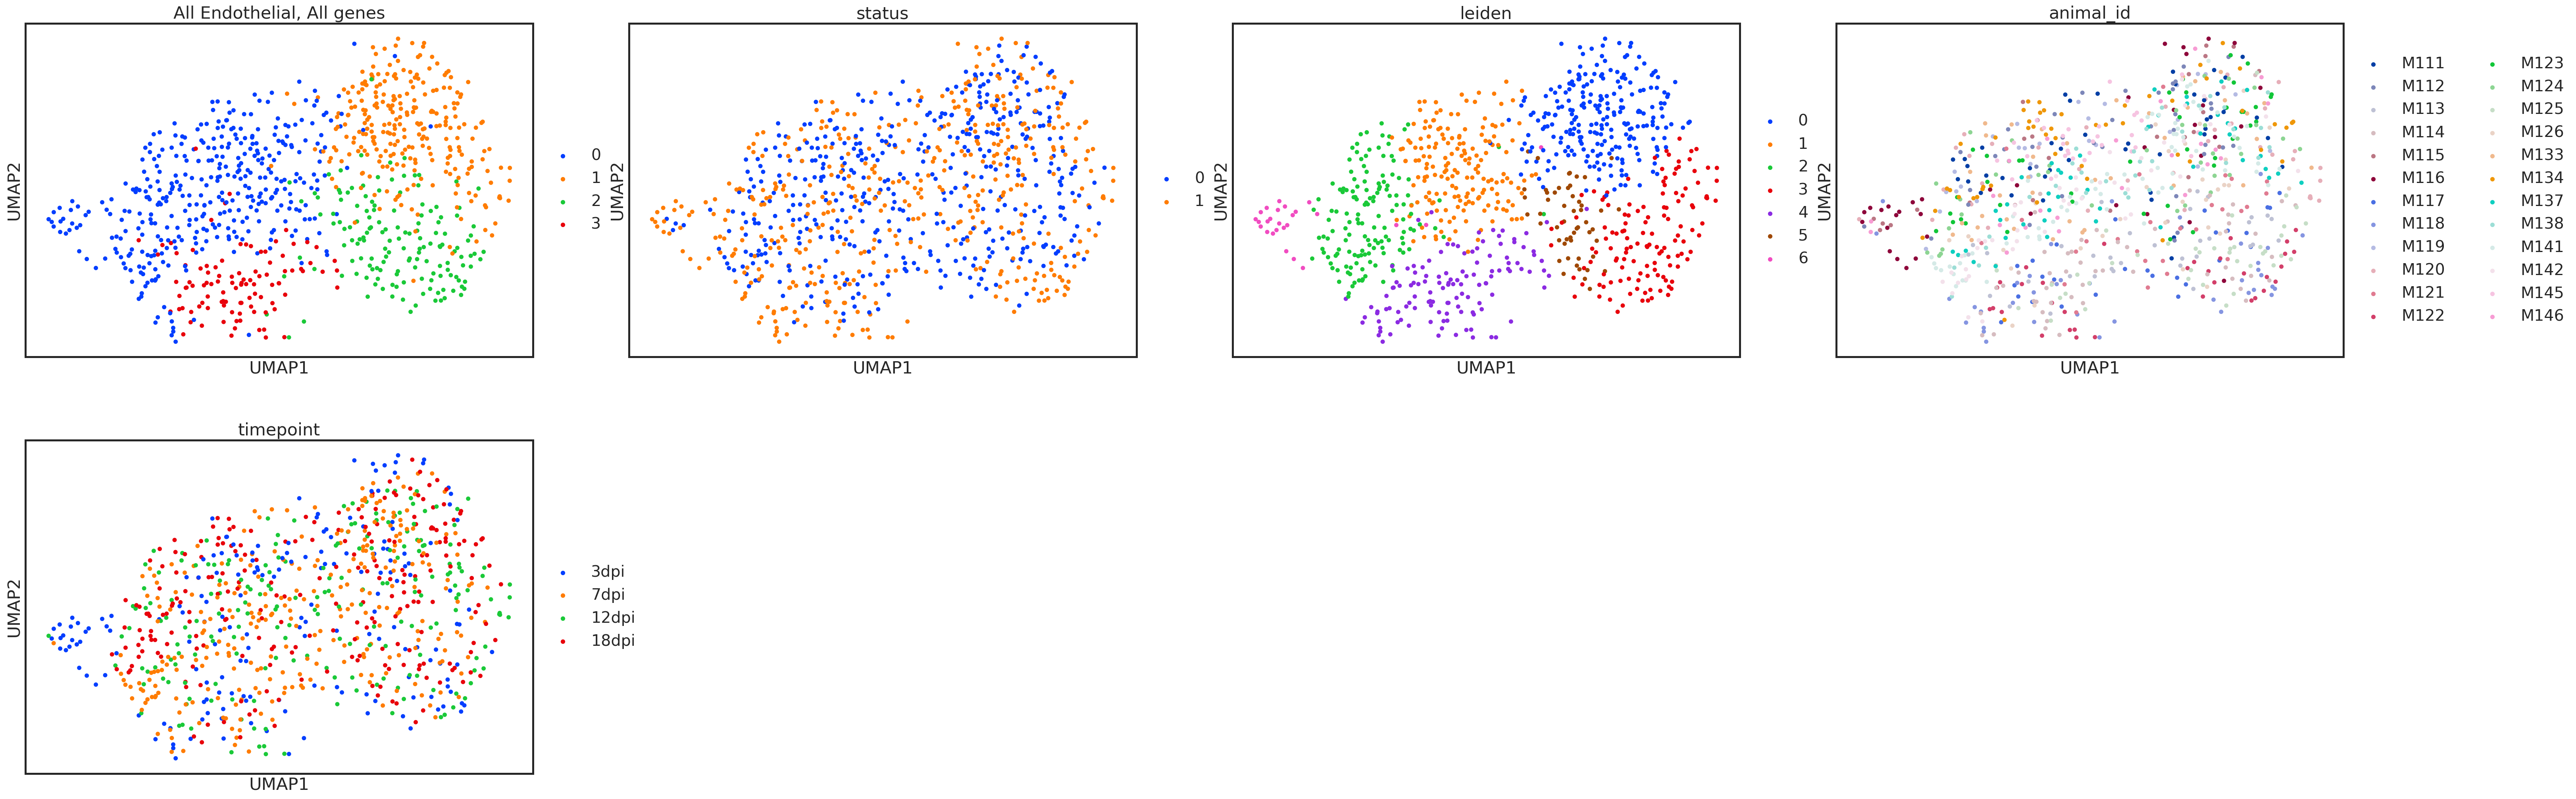

In [8]:
# Plotting
sc.pl.umap(adata, color=['cluster', 'status', 'leiden', 'animal_id', 'timepoint'], s=120,
           title='All Endothelial, All genes',
           save=f'_allgenes_{subset_title_str}.png')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


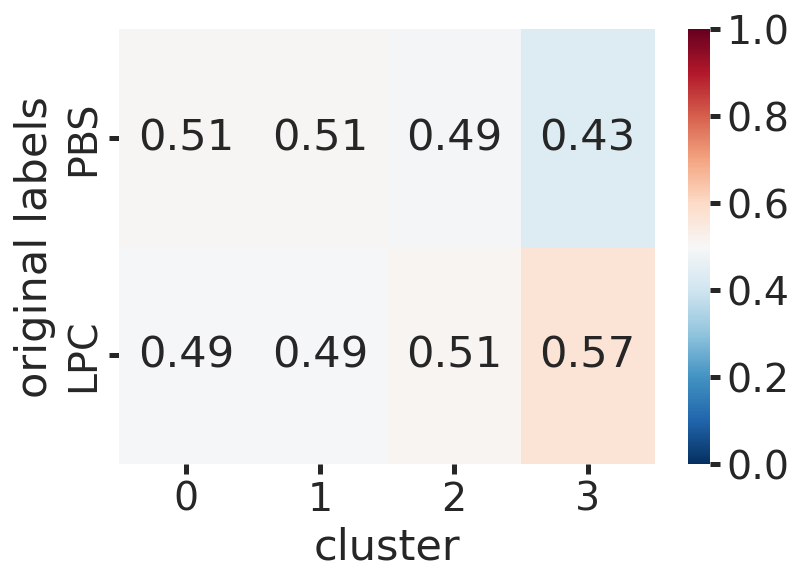

In [9]:
sub_df = adata.obs[['cluster', 'status']]
sub_df['count'] = 1

sub_df['original labels'] = sub_df['status'].apply(lambda x: 'PBS' if x==0 else 'LPC')

g = pd.pivot_table(sub_df, index=['original labels'], columns='cluster', values='count', aggfunc=np.sum)
g = g.apply(lambda x: x/np.sum(x))
plt.figure(figsize=(6, 4))
sns.heatmap(g, cmap='RdBu_r', annot=True, vmin=0, vmax=1)
plt.savefig(f'figures/table_cluster_{subset_title_str}.png', dpi=300, bbox_inches='tight')
plt.savefig(f'figures/table_cluster_{subset_title_str}.svg', bbox_inches='tight')
plt.savefig(f'figures/table_cluster_{subset_title_str}.pdf', bbox_inches='tight')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


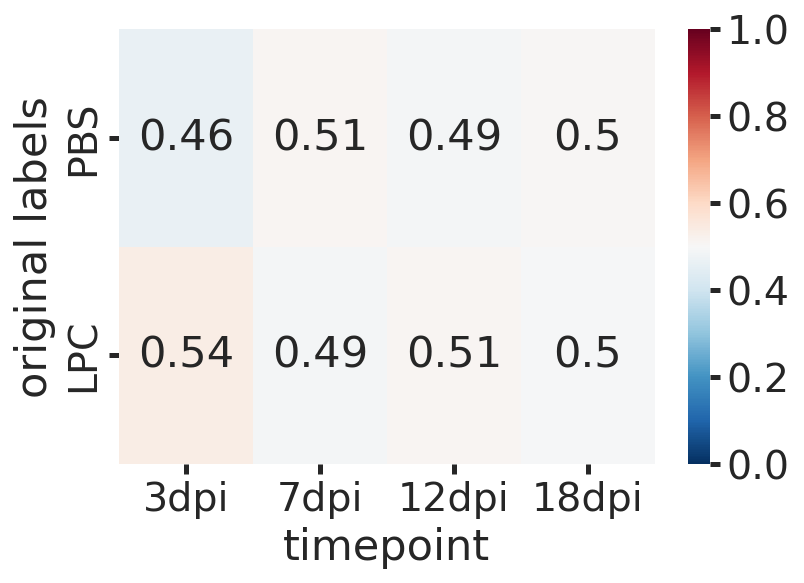

In [10]:
sub_df = adata.obs[['timepoint', 'status']]
sub_df['count'] = 1

sub_df['original labels'] = sub_df['status'].apply(lambda x: 'PBS' if x==0 else 'LPC')

g = pd.pivot_table(sub_df, index=['original labels'], columns='timepoint', values='count', aggfunc=np.sum)
g = g.apply(lambda x: x/np.sum(x))
plt.figure(figsize=(6, 4))
sns.heatmap(g, cmap='RdBu_r', annot=True, vmin=0, vmax=1)
plt.savefig(f'figures/table_timepoint_{subset_title_str}.png', dpi=300, bbox_inches='tight')
plt.savefig(f'figures/table_timepoint_{subset_title_str}.svg', bbox_inches='tight')
plt.savefig(f'figures/table_timepoint_{subset_title_str}.pdf', bbox_inches='tight')
plt.show()

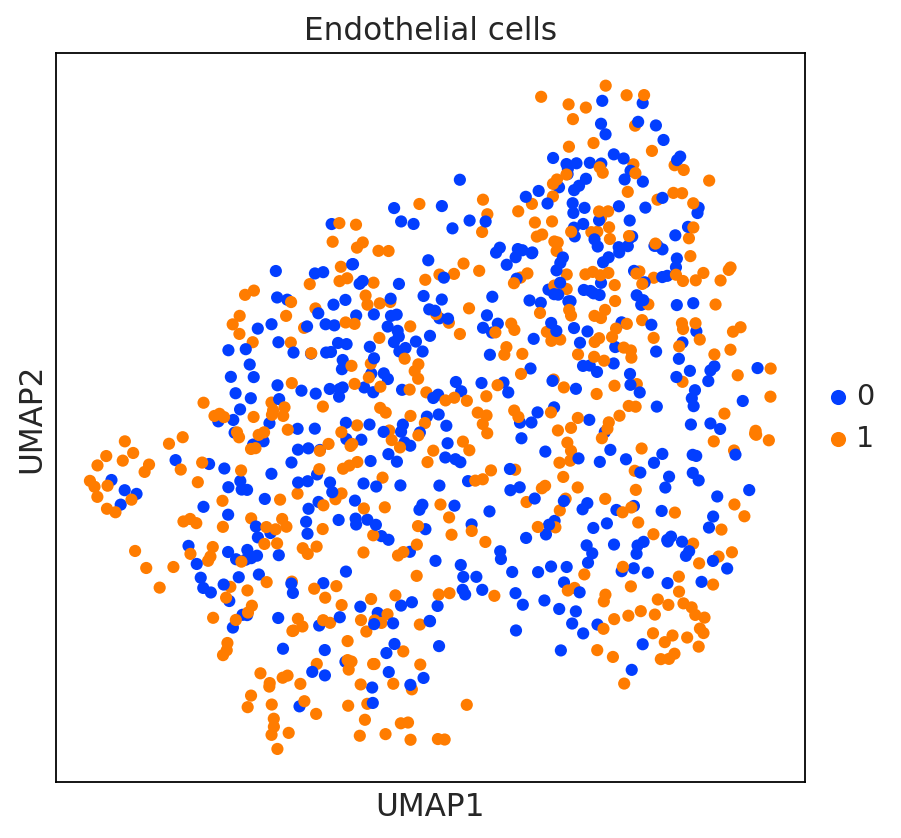

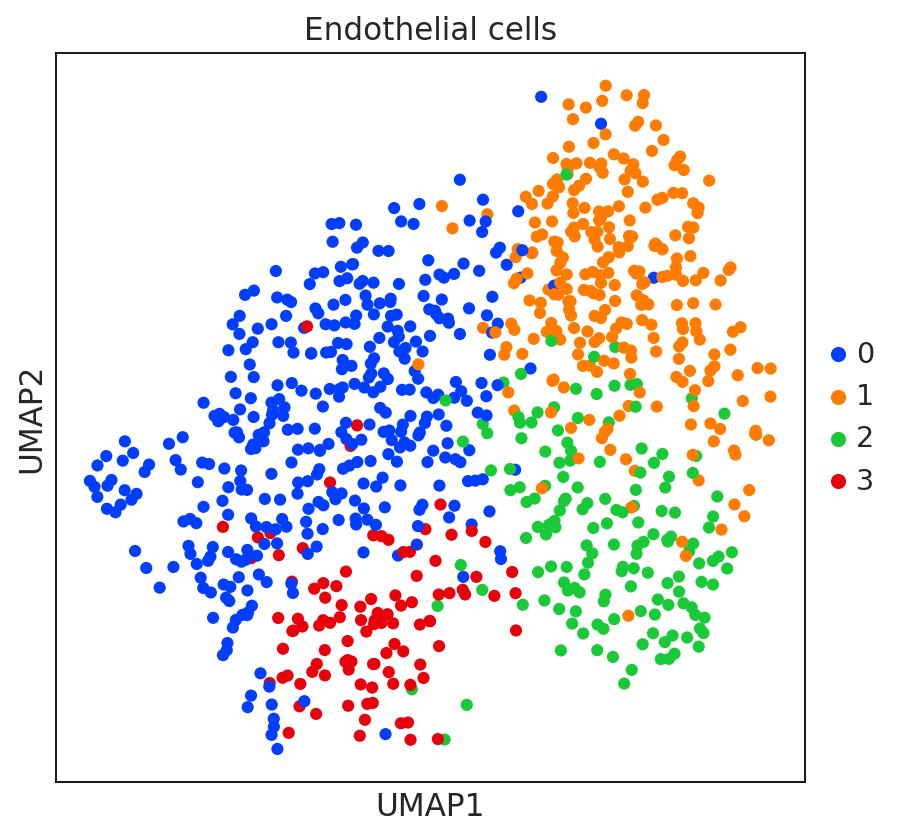

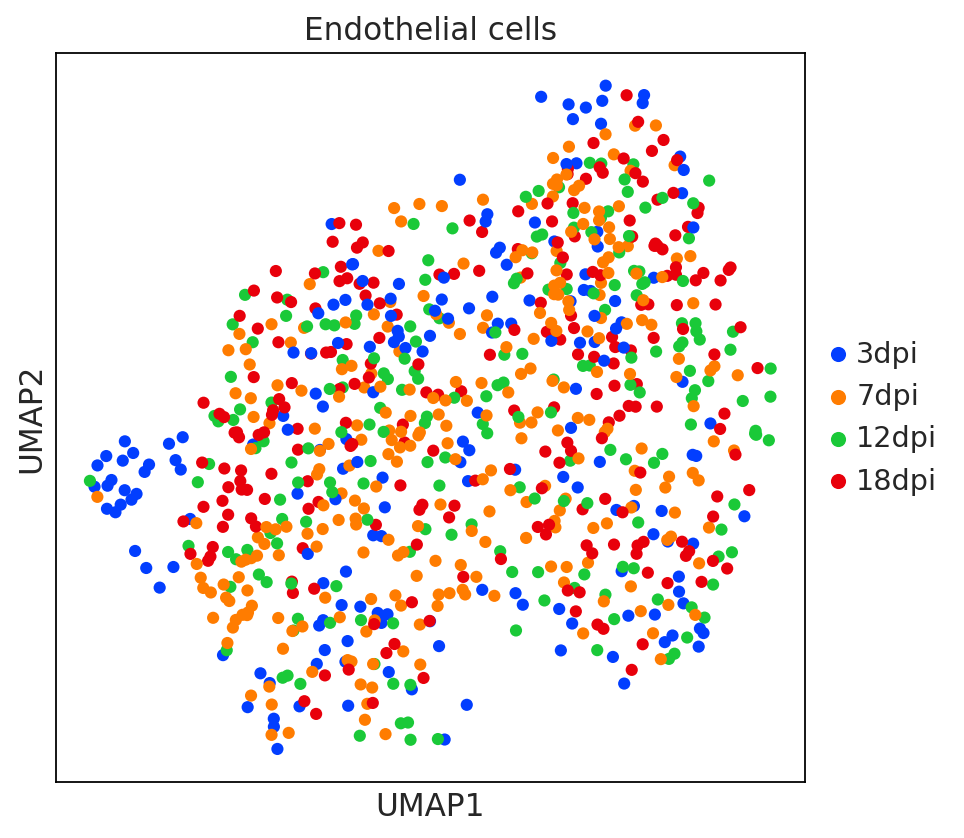

In [11]:
# Plotting
sc.set_figure_params(figsize=(6, 6))
sc.pl.umap(adata, color=['status'], s=120, title='Endothelial cells', save=f'_allgenes_status_{subset_title_str}.png')
#sc.pl.umap(adata, color=['status'], s=120, title='Endothelial cells', save=f'_allgenes_status_{subset_title_str}.svg')

sc.pl.umap(adata, color=['cluster'], s=120, title='Endothelial cells', save=f'_allgenes_cluster_{subset_title_str}.png')
#sc.pl.umap(adata, color=['cluster'], s=120, title='Endothelial cells', save=f'_allgenes_cluster_{subset_title_str}.svg')

sc.pl.umap(adata, color=['timepoint'], s=120, title='Endothelial cells', save=f'_allgenes_timepoint_{subset_title_str}.png')
#sc.pl.umap(adata, color=['timepoint'], s=120, title='Endothelial cells', save=f'_allgenes_timepoint_{subset_title_str}.svg')

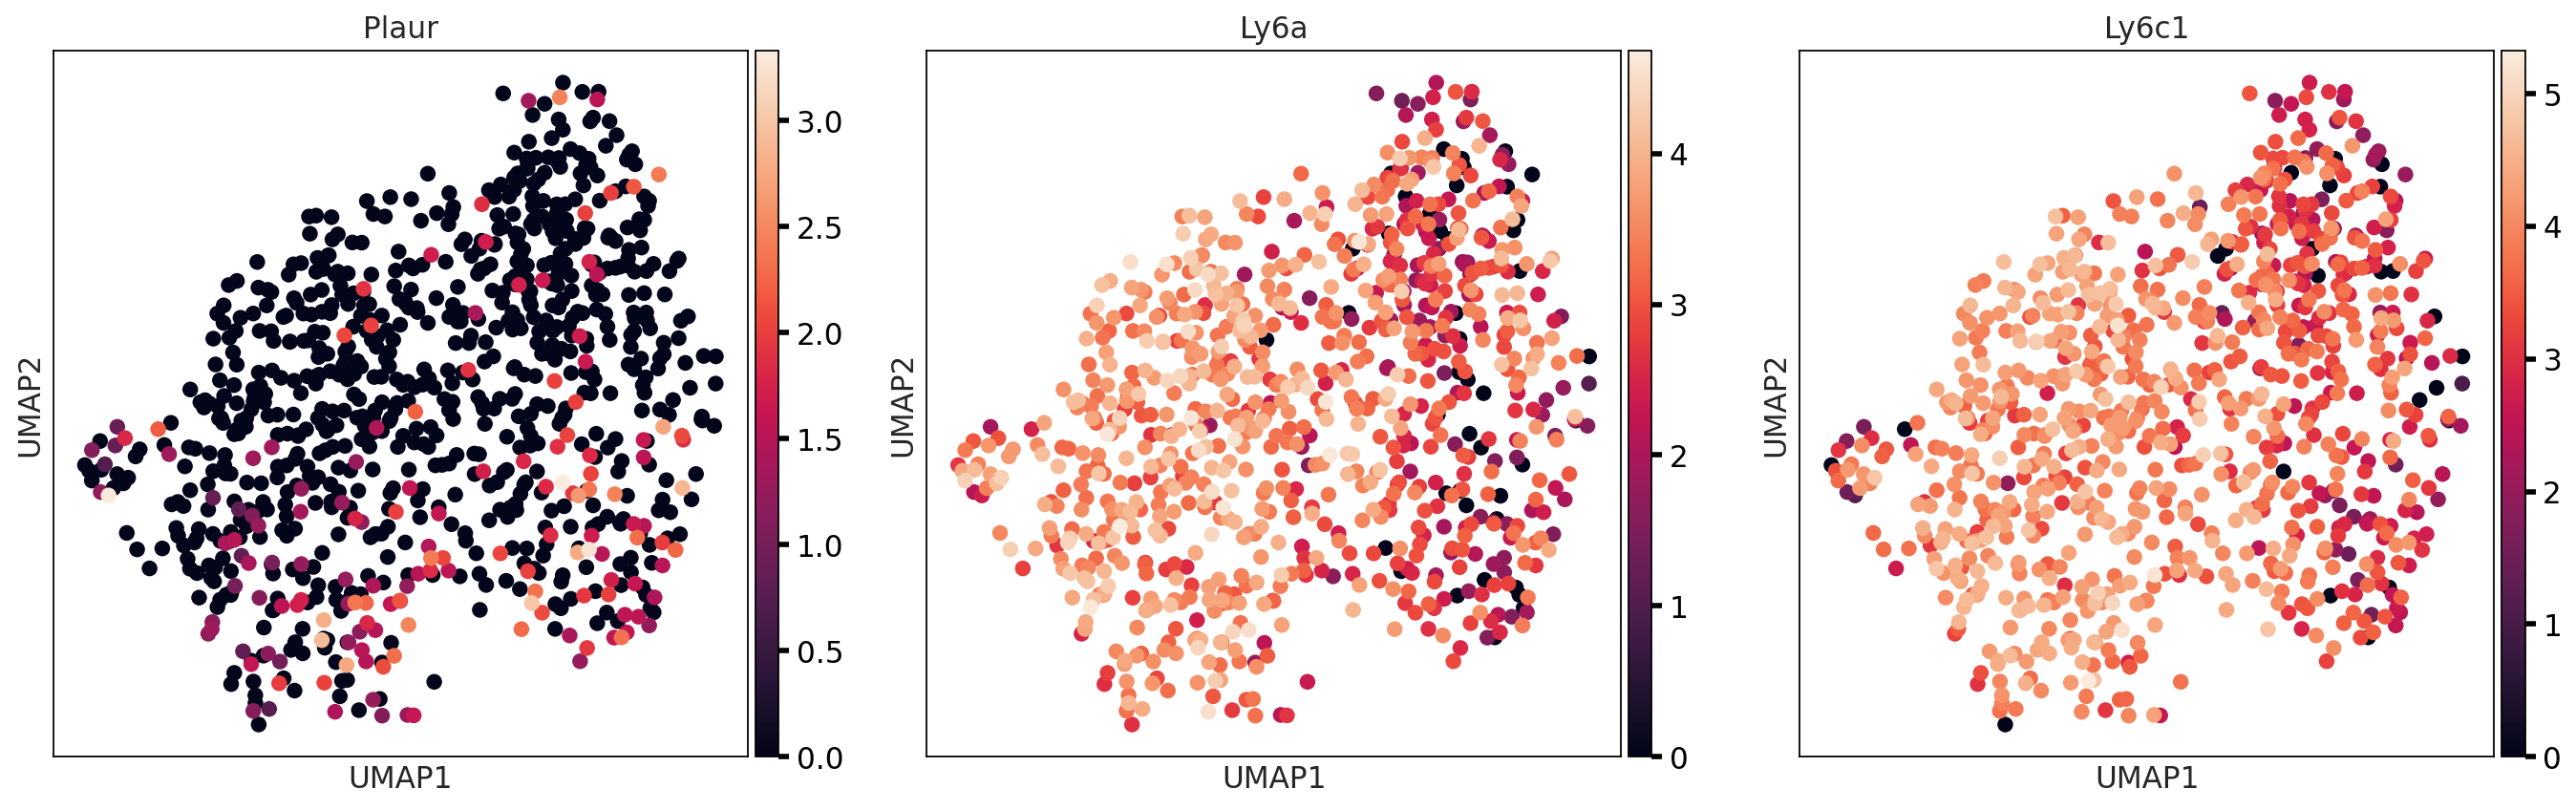

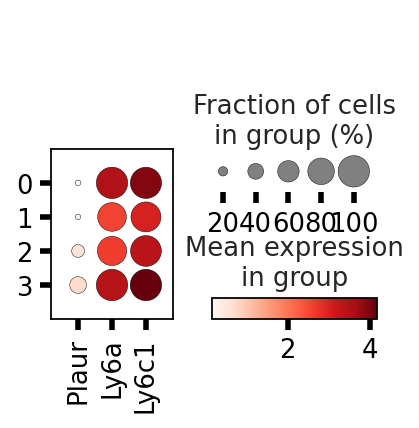

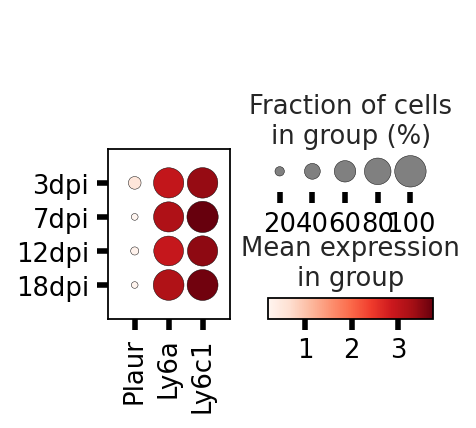

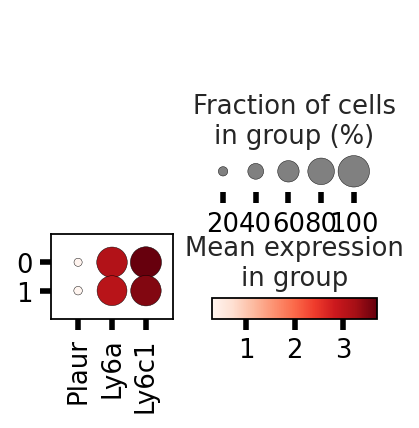

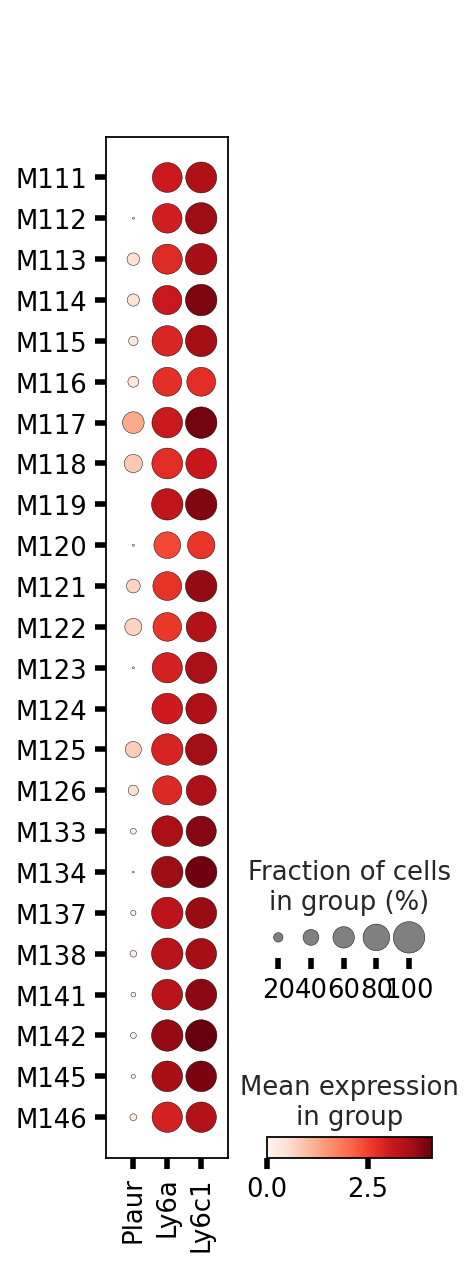

In [13]:
sc.pl.umap(adata, color=['Plaur', 'Ly6a', 'Ly6c1'], s=220)

sc.pl.dotplot(adata, ['Plaur', 'Ly6a', 'Ly6c1'], groupby='cluster')
sc.pl.dotplot(adata, ['Plaur', 'Ly6a', 'Ly6c1'], groupby='timepoint')
sc.pl.dotplot(adata, ['Plaur', 'Ly6a', 'Ly6c1'], groupby='status')
sc.pl.dotplot(adata, ['Plaur', 'Ly6a', 'Ly6c1'], groupby='animal_id')

### DE analysis

In [14]:
adata.obs['status'] = adata.obs['status'].astype('category')
sc.tl.rank_genes_groups(adata, 'status', method='wilcoxon')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

result_0_df = result_df[['0_n', '0_p', '0_l']]
result_1_df = result_df[['1_n', '1_p', '1_l']]
DEs_0 = result_0_df.loc[result_0_df['0_p']<0.05].loc[result_0_df['0_l']>0]['0_n'].values
DEs_1 = result_1_df.loc[result_1_df['1_p']<0.05].loc[result_1_df['1_l']>0]['1_n'].values
print(DEs_0.shape, DEs_1.shape, result_df.shape)

print(DEs_0)
print(DEs_1)

(6,) (20,) (16868, 6)
['Sgms1' 'Igf1r' 'Pltp' 'Dusp1' 'Sema3c' 'Nfkbia']
['Lyz2' 'Ctsd' 'Spp1' 'C1qa' 'Apoe' 'B2m' 'Ctss' 'H2-K1' 'H2-D1' 'Ifitm3'
 'Igfbp7' 'Gfap' 'Apod' 'Fth1' 'C1qb' 'Vim' 'Tmem252' 'Magi1' 'Fabp5'
 'Sparc']


In [15]:
sc.tl.rank_genes_groups(adata, 'animal_id', method='wilcoxon')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 

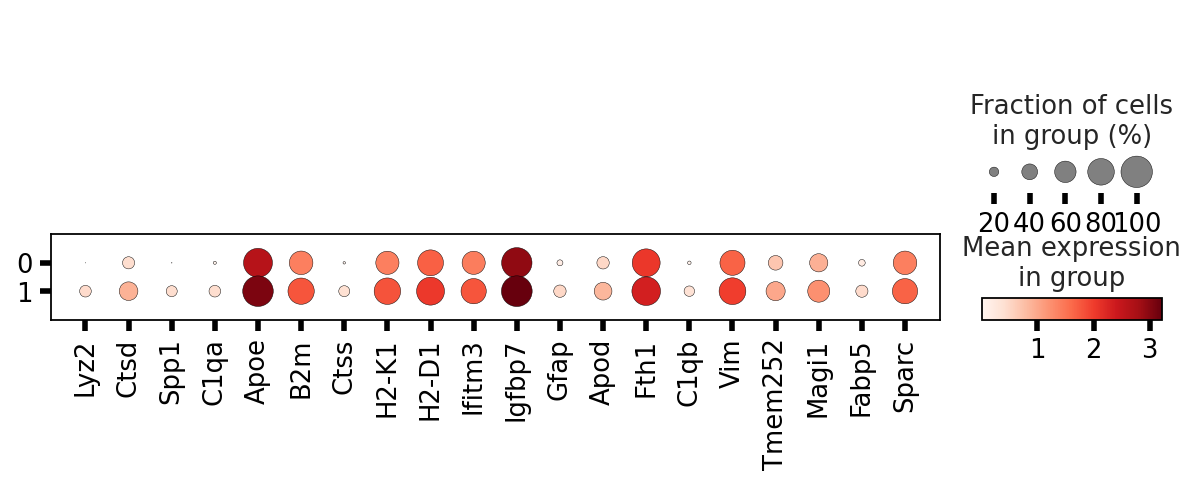

In [18]:
sc.pl.dotplot(adata, DEs_1, groupby='status')#, save=f'{subset_title_str}_DEs_M115.png')
#sc.pl.stacked_violin(adata, DEs_0, groupby='status', rotation=90)#, save=f'{subset_title_str}_DEs_M115.png')

In [19]:
sc.tl.rank_genes_groups(adata, 'timepoint', method='wilcoxon')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

result_3dpi_df = result_df[['3dpi_n', '3dpi_p', '3dpi_l']]
DEs_3dpi = result_3dpi_df.loc[result_3dpi_df['3dpi_p']<0.05].loc[result_3dpi_df['3dpi_l']>0]['3dpi_n'].values
print(DEs_3dpi)

result_7dpi_df = result_df[['7dpi_n', '7dpi_p', '7dpi_l']]
DEs_7dpi = result_7dpi_df.loc[result_7dpi_df['7dpi_p']<0.05].loc[result_7dpi_df['7dpi_l']>0]['7dpi_n'].values
print(DEs_7dpi)

result_12dpi_df = result_df[['12dpi_n', '12dpi_p', '12dpi_l']]
DEs_12dpi = result_12dpi_df.loc[result_12dpi_df['12dpi_p']<0.05].loc[result_12dpi_df['12dpi_l']>0]['12dpi_n'].values
print(DEs_12dpi)

result_18dpi_df = result_df[['18dpi_n', '18dpi_p', '18dpi_l']]
DEs_18dpi = result_18dpi_df.loc[result_18dpi_df['18dpi_p']<0.05].loc[result_18dpi_df['18dpi_l']>0]['18dpi_n'].values
print(DEs_18dpi)

['Spp1' 'Vim' 'Lyz2' 'Clic1' 'Sparc' 'Fabp5' 'Ctla2a' 'Fth1' 'Col4a2'
 'Adgrl3' 'Igfbp7' 'Ftl1' 'Gpx1' 'Lgals1' 'S100a6' 'Fn1' 'Eef1a1' 'Rtn4'
 'Sat1' 'Tmem252' 'Ecscr' 'Pmepa1']
['Itm2a' 'Gpcpd1' 'Pltp' 'Tsc22d3' 'Ptn' 'Ucp2']
[]
[]


In [21]:
sc.tl.rank_genes_groups(adata, 'cluster', method='wilcoxon')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

result_cl0_df = result_df[['0_n', '0_p', '0_l']]
DEs_cl0 = result_cl0_df.loc[result_cl0_df['0_p']<0.05].loc[result_cl0_df['0_l']>2]['0_n'].values
print(DEs_cl0)

result_cl1_df = result_df[['1_n', '1_p', '1_l']]
DEs_cl1 = result_cl1_df.loc[result_cl1_df['1_p']<0.05].loc[result_cl1_df['1_l']>2]['1_n'].values
print(DEs_cl1)

result_cl2_df = result_df[['2_n', '2_p', '2_l']]
DEs_cl2 = result_cl2_df.loc[result_cl2_df['2_p']<0.05].loc[result_cl2_df['2_l']>2]['2_n'].values
print(DEs_cl2)

result_cl3_df = result_df[['3_n', '3_p', '3_l']]
DEs_cl3 = result_cl3_df.loc[result_cl3_df['3_p']<0.05].loc[result_cl3_df['3_l']>2]['3_n'].values
print(DEs_cl3)

['Rps29' 'Rgs5' 'Cxcl12' 'Gm10076' 'mt-Nd4' 'Rpl36-ps3' 'Uqcr11' 'Slc1a2'
 'Atp1a2' 'Ndrg2' 'Ndufa1' 'Cetn2' 'Tspan7' 'Myl9' 'Igsf8' 'Vtn' 'Ptprz1'
 'Ndufa4l2' 'Cox17' 'Nbl1' 'Slc1a3' 'Atp1b2' 'Ifitm1' 'Pla2g7' 'Higd1b'
 'Slc25a39' 'Des']
['Il1r1' 'Gm2163' 'Cysltr1']
['Timp3' 'Cyr61' 'Vcl' 'Adamts1' 'Mannr' 'Gkn3' 'Bmx' 'Sema3g' 'Fos']
['Klf2' 'Ier2' 'Btg2' 'Jun' 'Apold1' 'Dusp1' 'Jund' 'Klf4' 'Zfp36' 'Rgs5'
 'Cyr61' 'Junb' 'Atf3' 'Nr4a1' 'Sgk1' 'Cdkn1a' '9330111N05Rik' 'Fos'
 'Maff' 'Egr1' 'Tnfrsf12a' '1810011O10Rik' 'Dusp8']


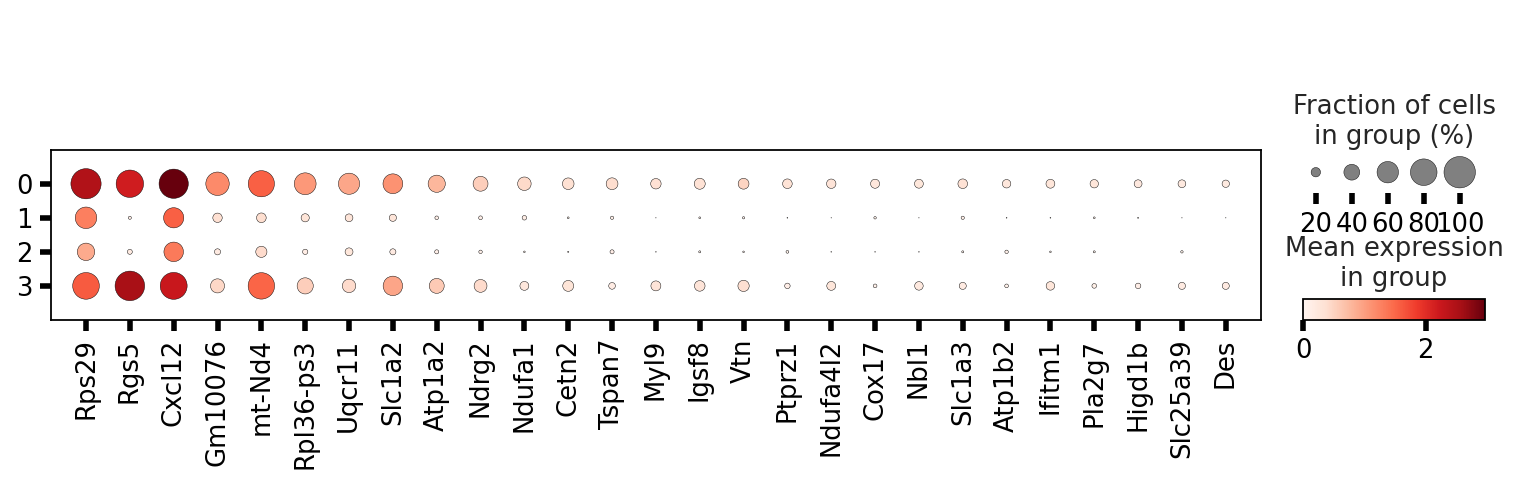

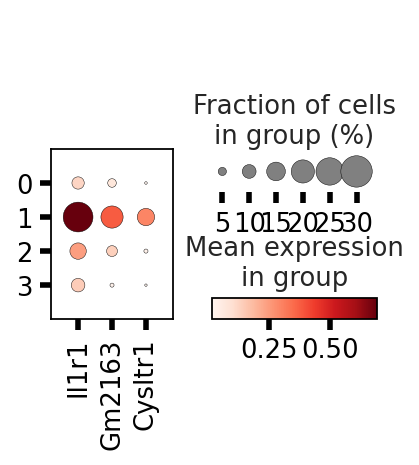

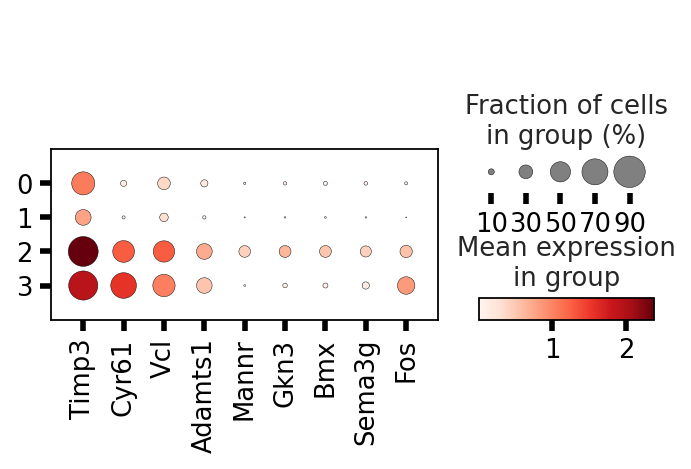

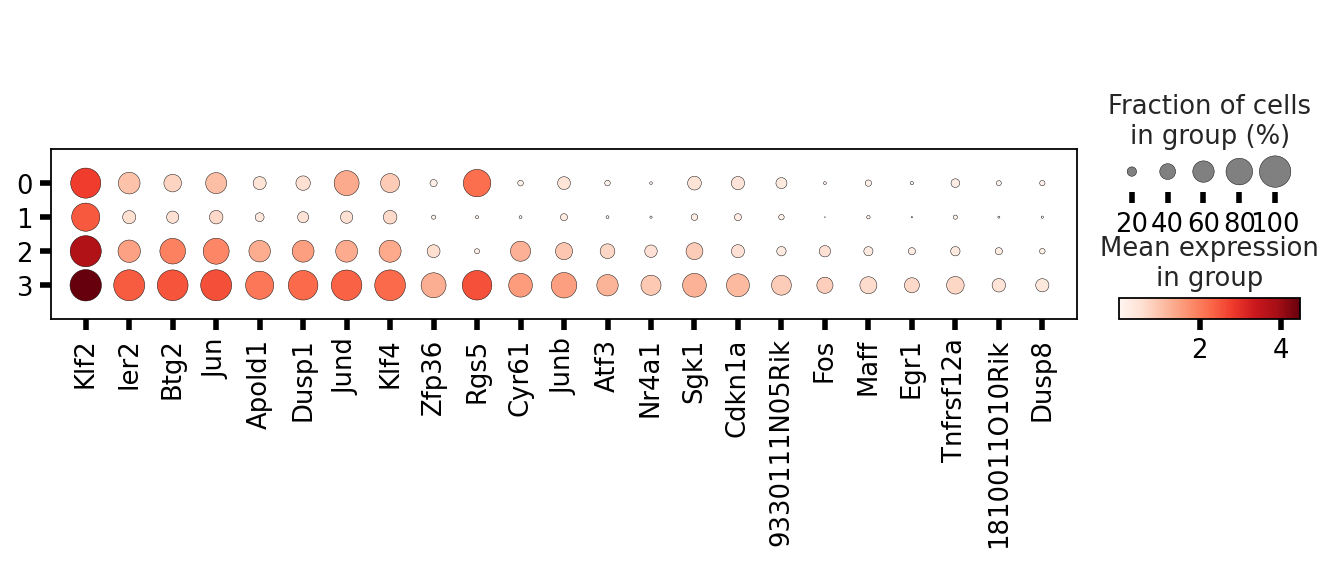

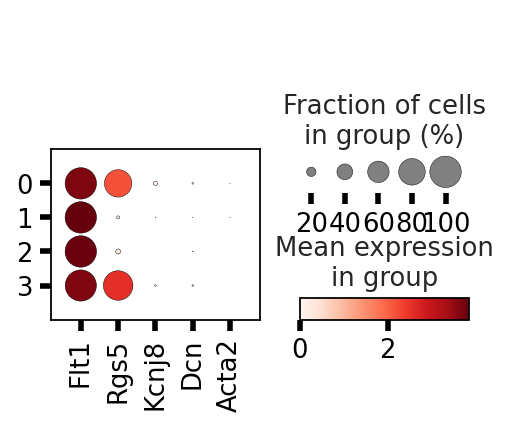

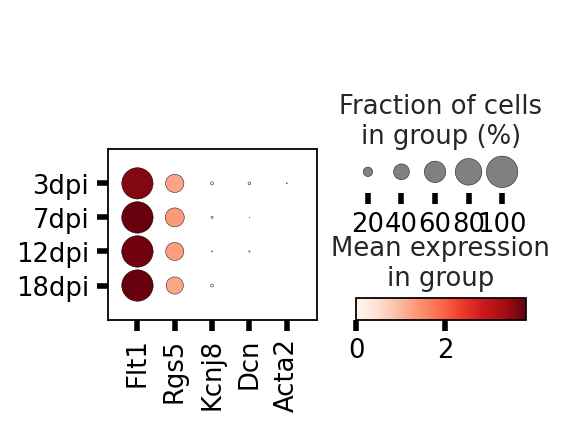

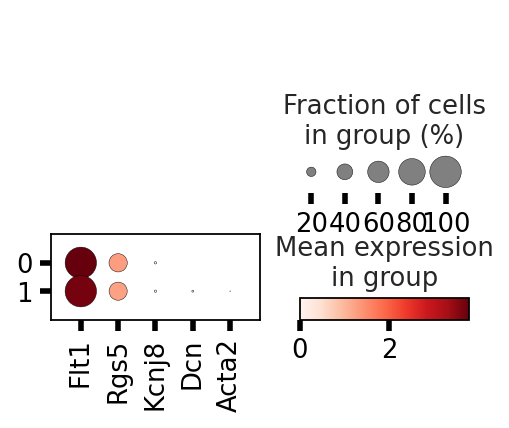

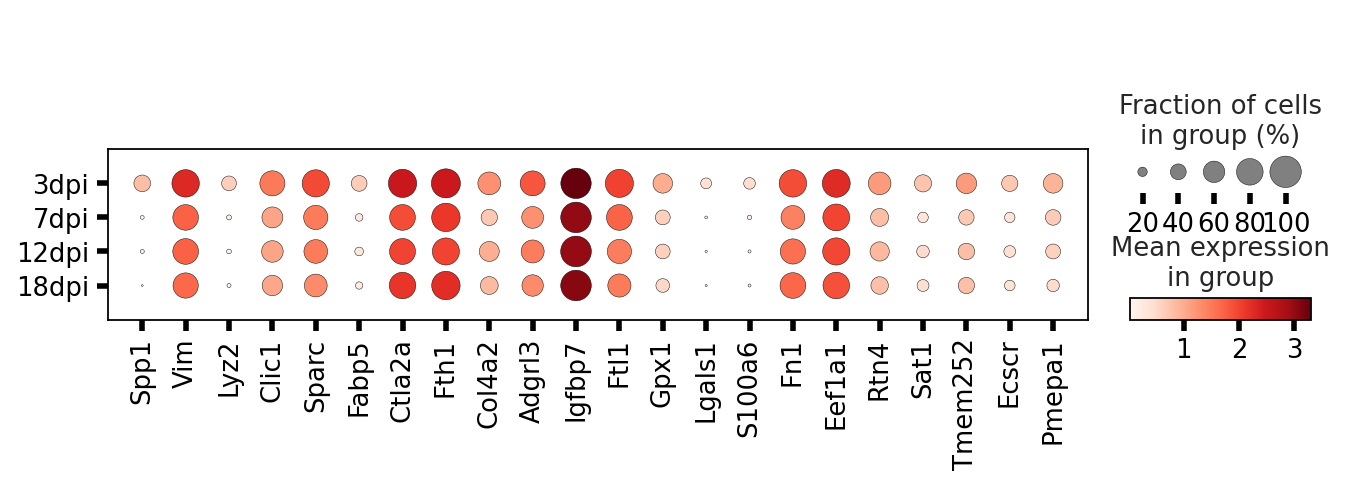

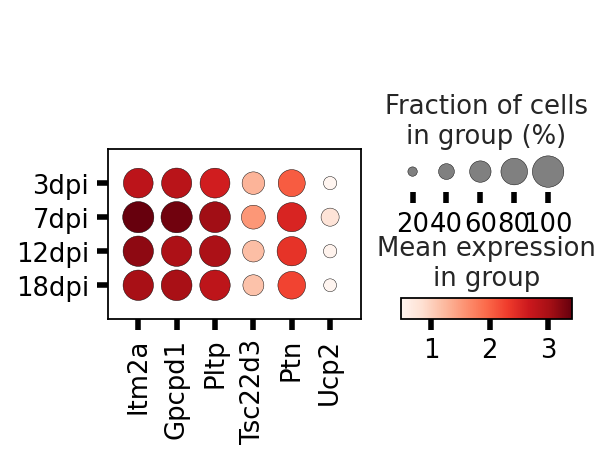

In [22]:
sc.pl.dotplot(adata, DEs_cl0, groupby='cluster', save=f'_cluster0_DEs_{subset_title_str}.png')
sc.pl.dotplot(adata, DEs_cl1, groupby='cluster', save=f'_cluster1_DEs_{subset_title_str}.png')
sc.pl.dotplot(adata, DEs_cl2, groupby='cluster', save=f'_cluster2_DEs_{subset_title_str}.png')
sc.pl.dotplot(adata, DEs_cl3, groupby='cluster', save=f'_cluster3_DEs_{subset_title_str}.png')

sc.pl.dotplot(adata, ['Flt1', 'Rgs5', 'Kcnj8', 'Dcn', 'Acta2'], groupby='cluster')#, 
              #save=f'_endothelial_markers_bycluster_{subset_title_str}.png')
sc.pl.dotplot(adata, ['Flt1', 'Rgs5', 'Kcnj8', 'Dcn', 'Acta2'], groupby='timepoint')#, 
              #save=f'_endothelial_markers_bytimepoint_{subset_title_str}.png')
sc.pl.dotplot(adata, ['Flt1', 'Rgs5', 'Kcnj8', 'Dcn', 'Acta2'], groupby='status')#, 
              #save=f'_endothelial_markers_bystatus_{subset_title_str}.png')

sc.pl.dotplot(adata, DEs_3dpi, groupby='timepoint')#, save=f'_3dpi_DEs_{subset_title_str}.png')
sc.pl.dotplot(adata, DEs_7dpi, groupby='timepoint')#, save=f'_7dpi_DEs_{subset_title_str}.png')

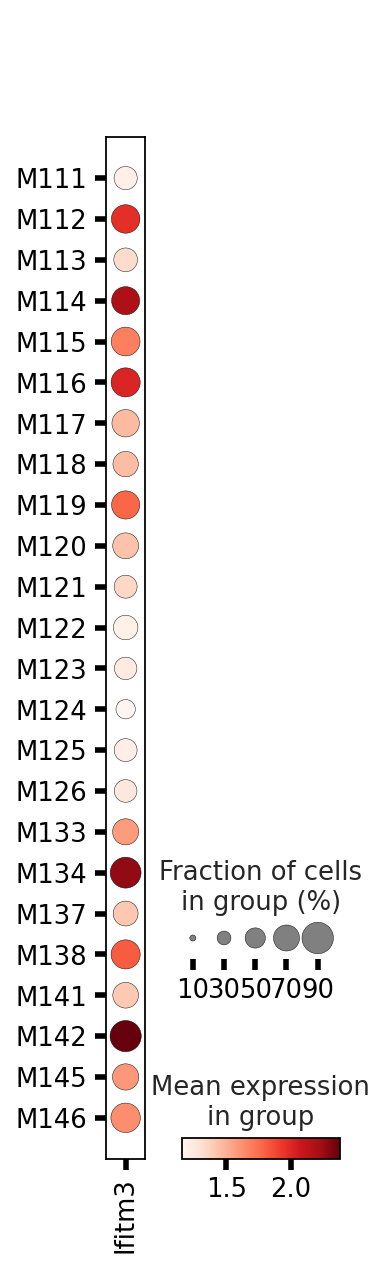

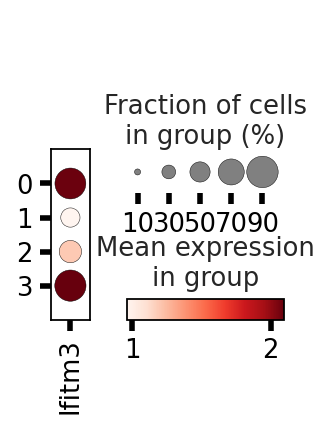

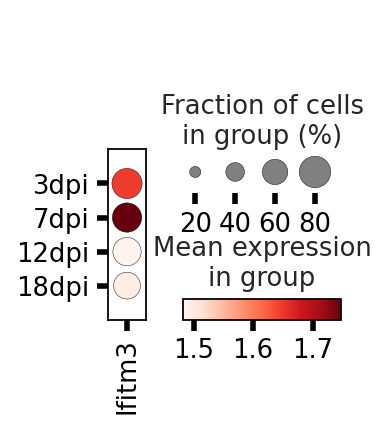

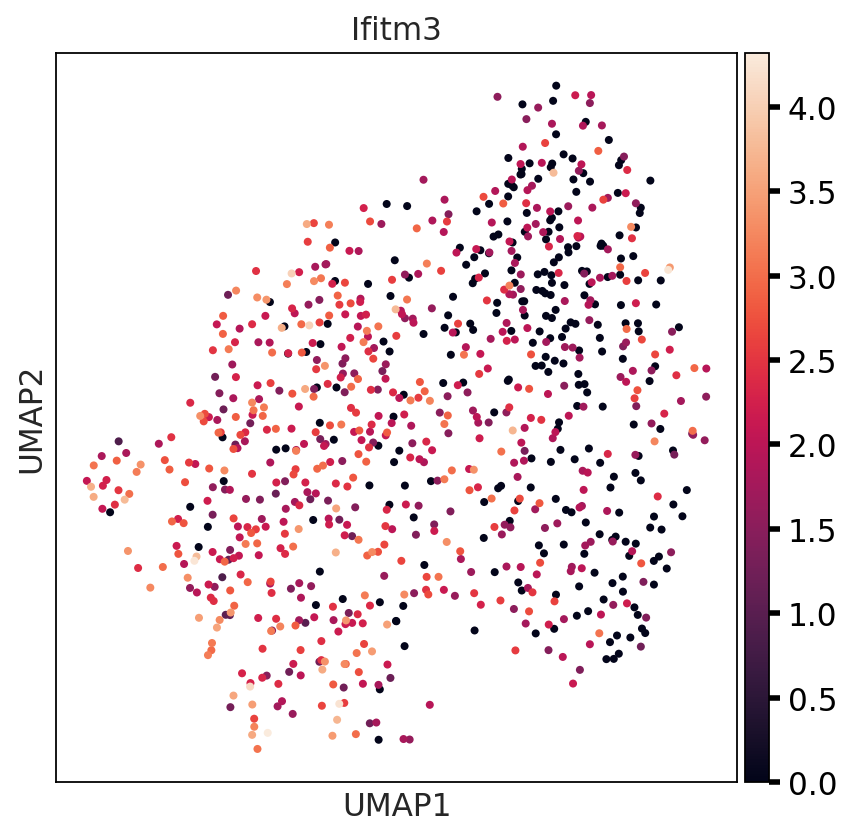

In [23]:
sc.pl.dotplot(adata, ['Ifitm3'], groupby='animal_id')
sc.pl.dotplot(adata, ['Ifitm3'], groupby='cluster')
sc.pl.dotplot(adata, ['Ifitm3'], groupby='timepoint')
sc.pl.umap(adata, color=['Ifitm3'], s=52)
#sc.pl.stacked_violin(adata, DEs_M115, groupby='animal_id', rotation=90, save=f'{subset_title_str}_DEs_M115.png')

## Run HiDDEN

In [24]:
output_path = f'figures/'
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [25]:
CASE_COND = 1

In [26]:
def standalone_logistic(X, y):
    clf = LogisticRegression(random_state=RAND_SEED, penalty='none').fit(X, y)
    predicted_label = clf.predict(X)
    predicted_prob = clf.predict_proba(X)
    return predicted_prob[:,1]

def PCA_logistic_kmeans(adata, num_pcs):
    
    p_hat = standalone_logistic(adata.obsm['X_pca'][:, 0:num_pcs], adata.obs['status'].values)
    df_p_hat = pd.DataFrame()
    df_p_hat['p_hat'] = p_hat
    df_p_hat['status'] = adata.obs['status'].values
    df_p_hat['animal_id'] = adata.obs['animal_id'].values
    adata.obs['p_hat'] = p_hat
    logit_p_hat = logit(p_hat)
    df_p_hat['logit_p_hat'] = logit_p_hat
    adata.obs['logit_p_hat'] = logit_p_hat

    kmeans_case = KMeans(n_clusters=2, random_state=0).fit(pd.DataFrame(logit(p_hat))[(adata.obs['status']==CASE_COND).values])
    mean_p_hat_kmeans_label0 = np.mean(p_hat[(adata.obs['status']==CASE_COND).values][kmeans_case.labels_==0]) 
    mean_p_hat_kmeans_label1 = np.mean(p_hat[(adata.obs['status']==CASE_COND).values][kmeans_case.labels_==1])
    zero_lab_has_lower_mean = mean_p_hat_kmeans_label0 < mean_p_hat_kmeans_label1

    df_p_hat_clust_case = df_p_hat.copy()
    df_p_hat_clust_case['kmeans'] = 0
    df_p_hat_clust_case['kmeans'][(adata.obs['status']==CASE_COND).values] = [1 if x==int(zero_lab_has_lower_mean) else 0 for x in kmeans_case.labels_]
    
       
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    sns.histplot(x=logit_p_hat, hue='status',
                 #palette={0:"#1B9E77", CASE_COND:"#D95F02"}, 
                 data=df_p_hat, ax=ax1)
    ax1.set_title(f'distr. of logit(p_hat), orig labels, all cells')
    sns.histplot(x=logit_p_hat, hue='kmeans', data=df_p_hat_clust_case, ax=ax2)
    ax2.set_title(f'distr. of logit(p_hat), new labels, all cells')
    plt.savefig(f'figures/logit_p_hat_clust_case_pcs{num_pcs}_{CASE_COND}.png')
    plt.show()
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    sns.histplot(x=p_hat, hue='status', 
                 #palette={0:"#1B9E77", CASE_COND:"#D95F02"}, 
                 data=df_p_hat, ax=ax1)
    ax1.set_title(f'distr. of p_hat, orig labels, all cells')
    sns.histplot(x=p_hat, hue='kmeans', data=df_p_hat_clust_case, ax=ax2)
    ax2.set_title(f'distr. of p_hat, new labels, all cells')
    plt.savefig(f'figures/p_hat_clust_case_pcs{num_pcs}_{CASE_COND}.png')
    plt.show()
    
    return p_hat, df_p_hat_clust_case['kmeans']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


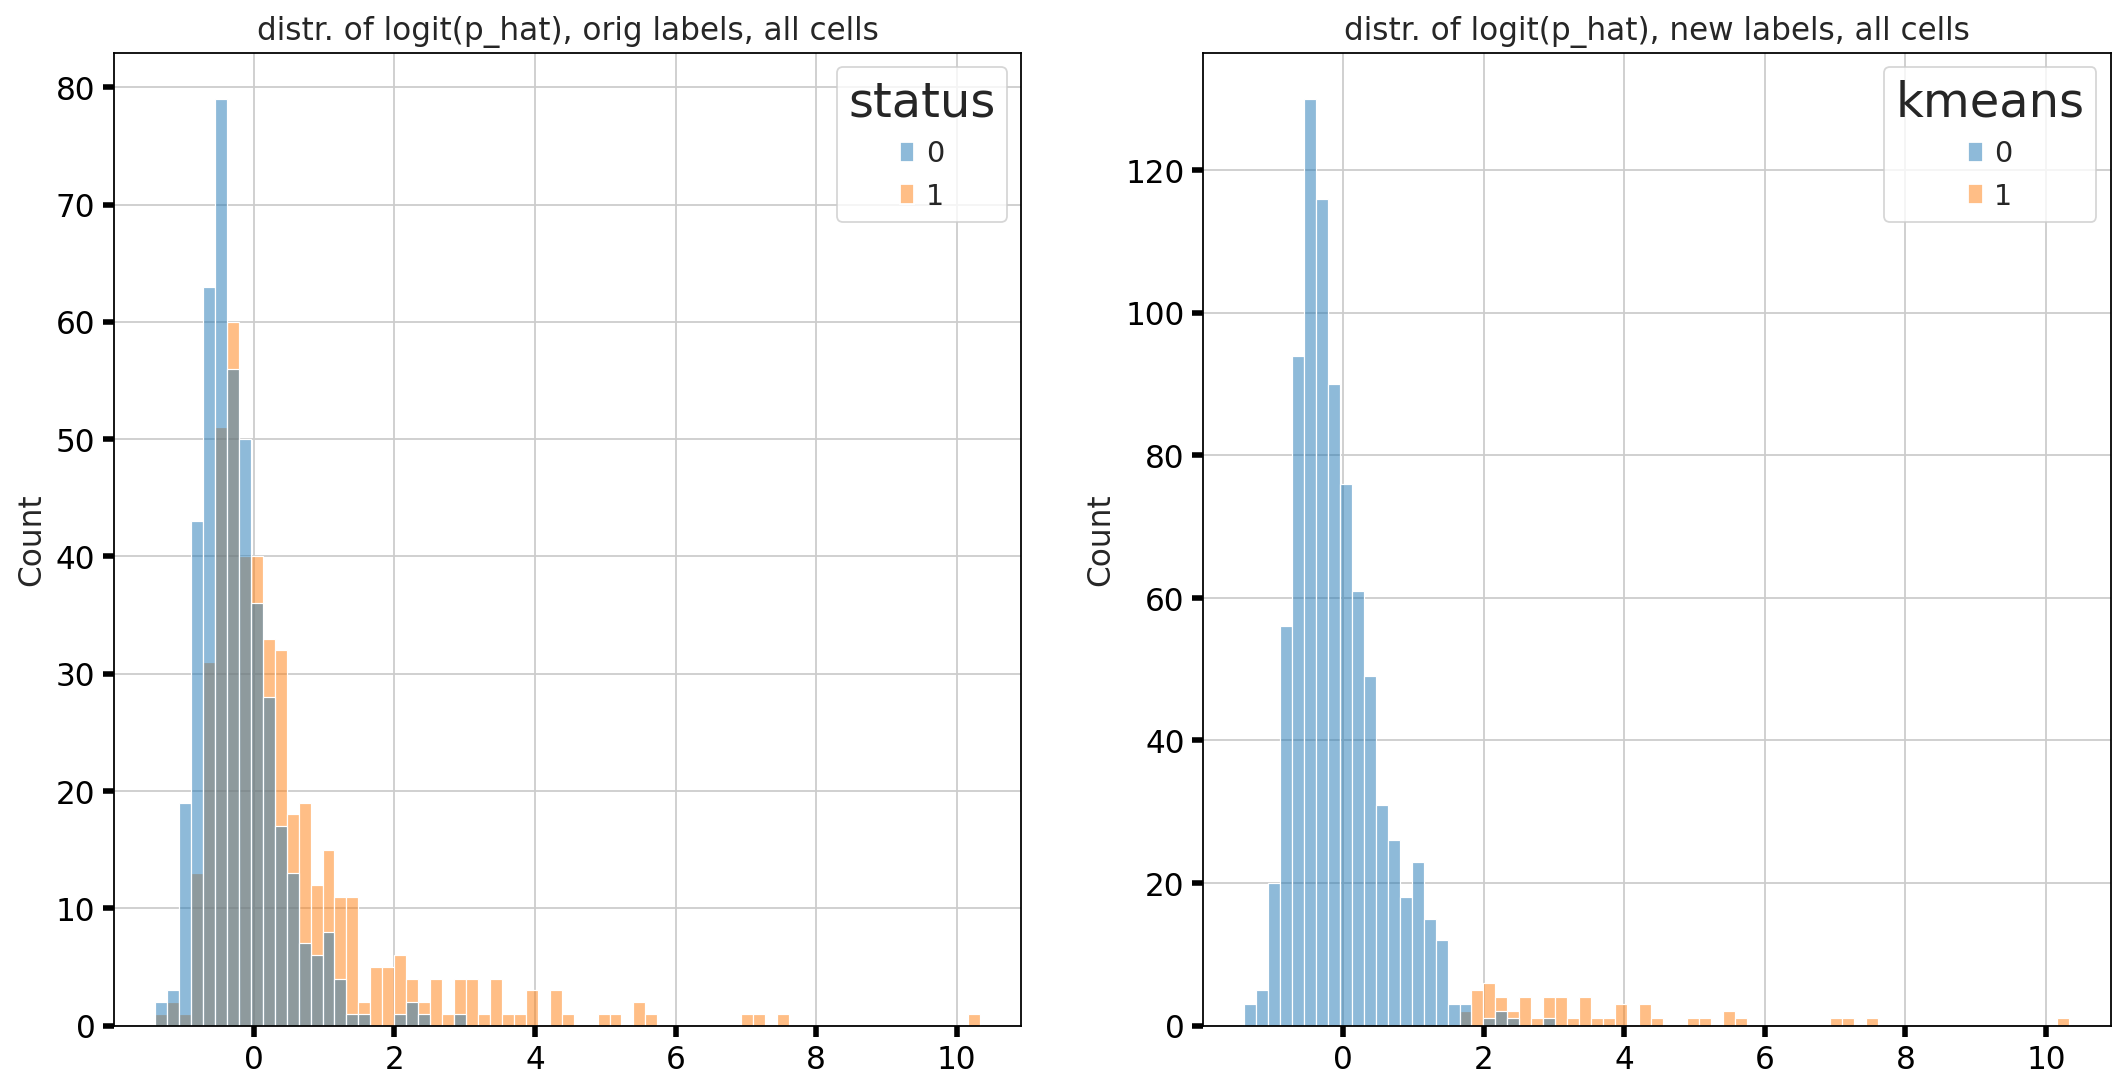

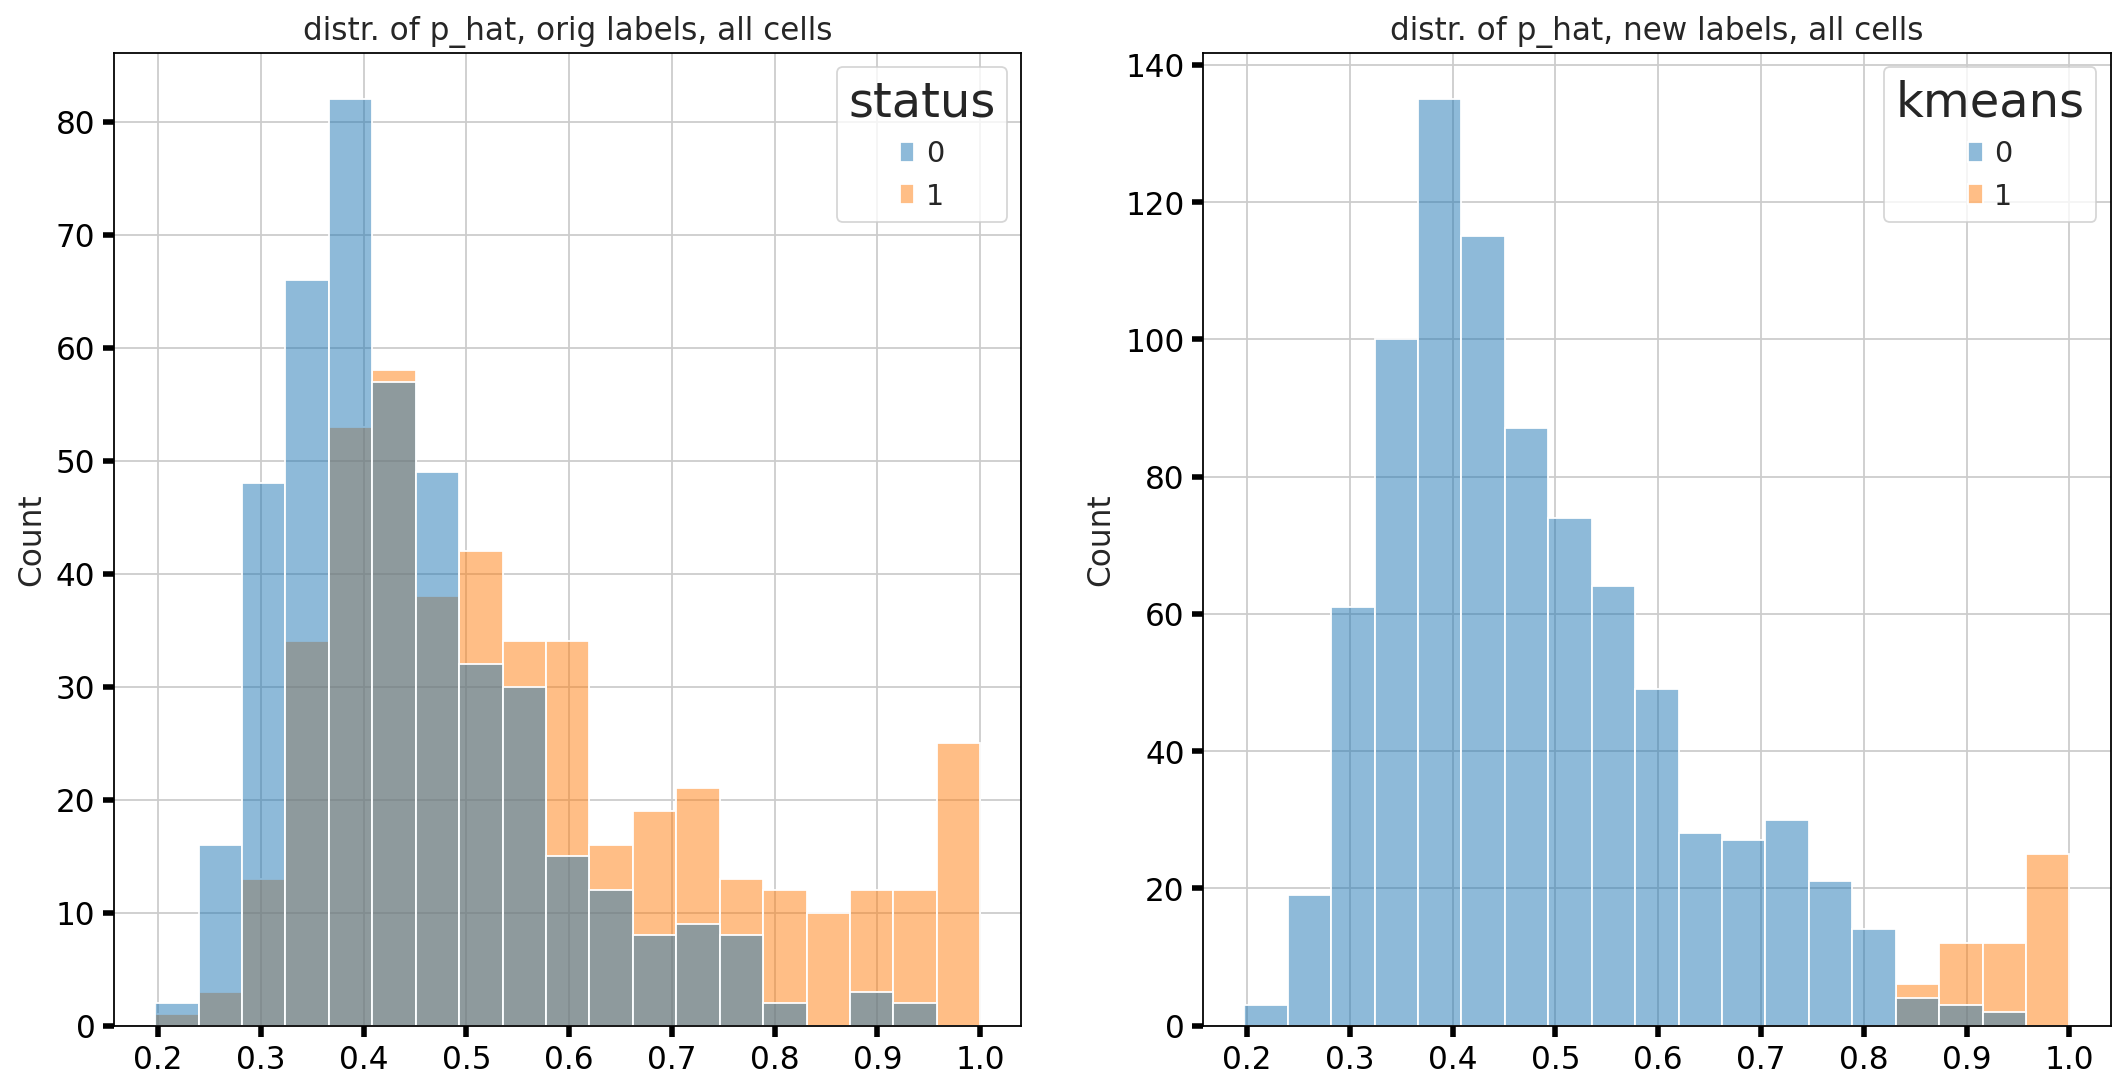

In [27]:
NUM_PCS = 5
adata.obs['status'] = adata.obs['status'].astype('int').values
p_hat, new_labels = PCA_logistic_kmeans(adata, num_pcs=NUM_PCS)

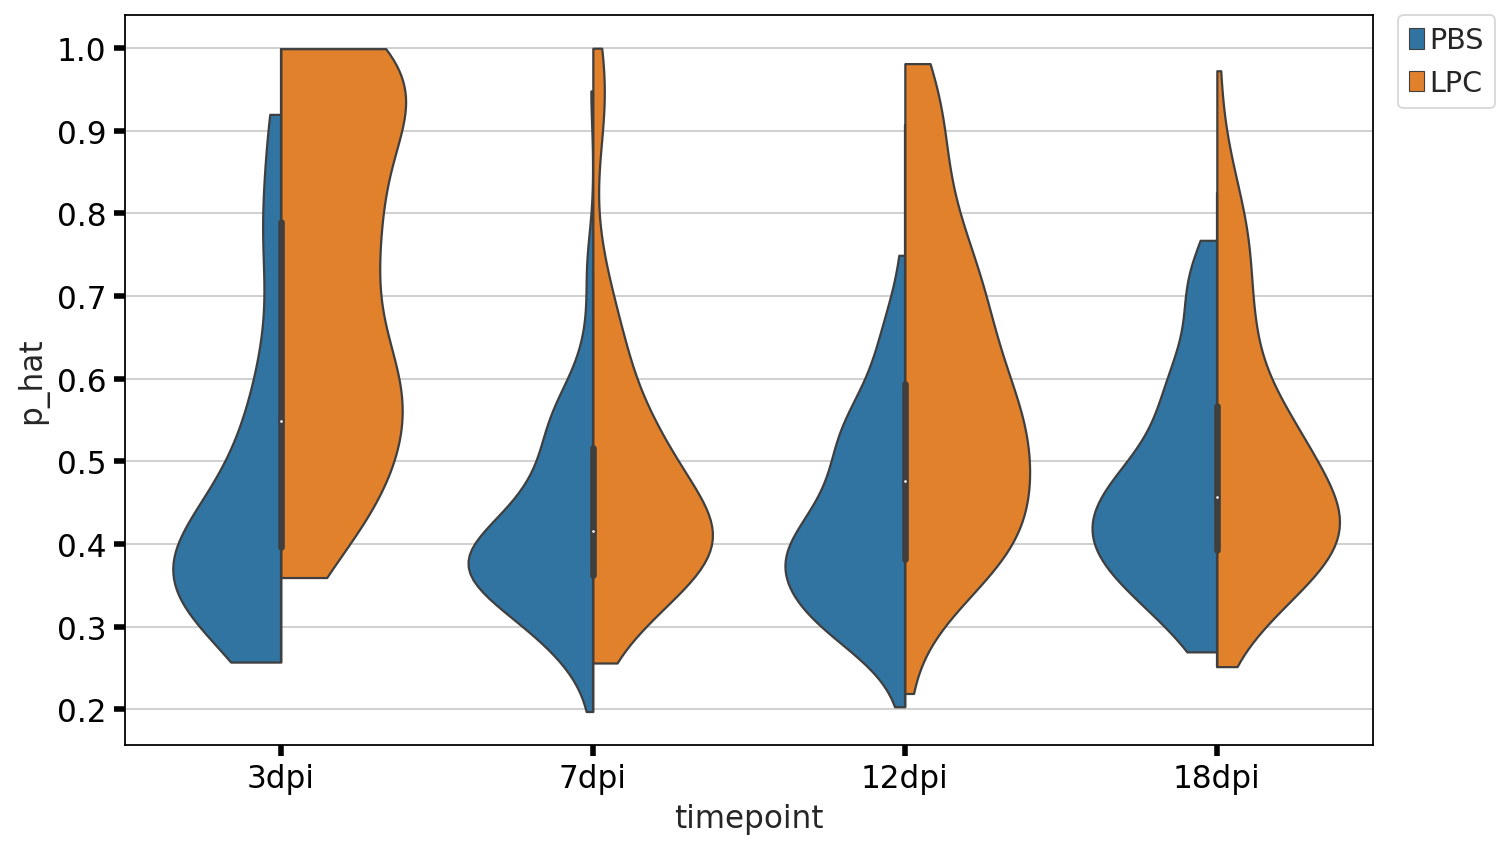

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


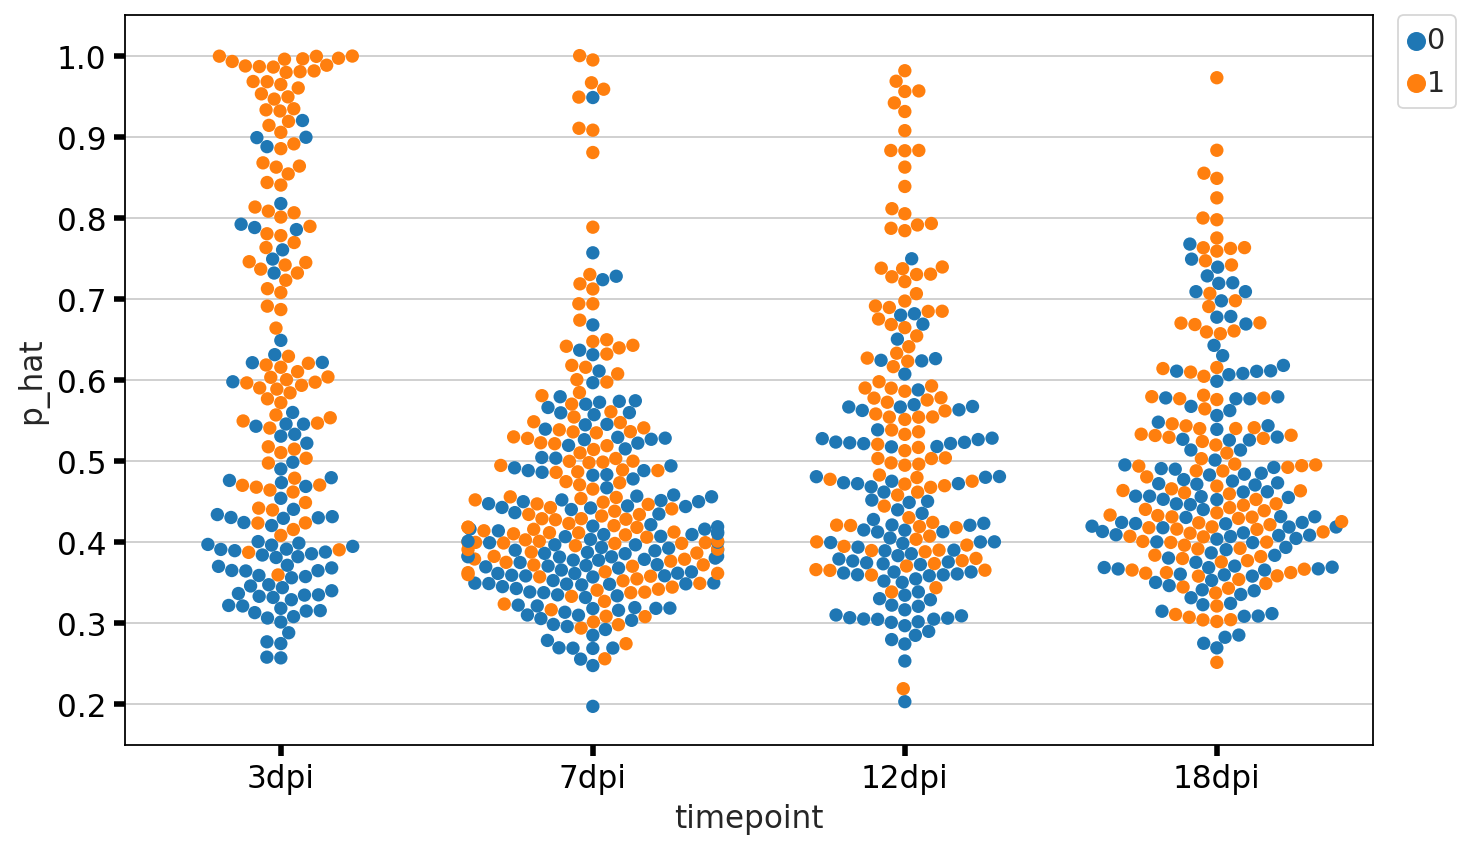

In [28]:
df = sc.get.obs_df(adata, ['p_hat', 'logit_p_hat', 'timepoint', 'status', 'animal_id', 'cluster'])
df.columns = ['p_hat', 'logit_p_hat', 'timepoint', 'status', 'animal_id', 'cluster']
df['original_labels'] = df['status'].apply(lambda x: 'PBS' if x==0 else 'LPC')

plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='timepoint', y='p_hat', hue="original_labels", split=True, linewidth=1, scale='count', cut=0) 
#plt.title(f"{subset_title_str} \n Area is scaled by count")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, handletextpad=0.2)
#plt.legend(loc='upper right', borderaxespad=0)
plt.savefig(f'figures/splitviolin_p_hat_timepoint_pcs{NUM_PCS}_{CASE_COND}_{subset_title_str}.png', dpi=300, bbox_inches='tight')
plt.savefig(f'figures/splitviolin_p_hat_timepoint_pcs{NUM_PCS}_{CASE_COND}_{subset_title_str}.svg', bbox_inches='tight')
plt.savefig(f'figures/splitviolin_p_hat_timepoint_pcs{NUM_PCS}_{CASE_COND}_{subset_title_str}.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
sns.swarmplot(data=df, x='timepoint', y='p_hat', hue="status", size=6) 
#plt.title(f"{subset_title_str} \n Area is scaled by count")
plt.ylim(0.15, 1.05)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, handletextpad=0.1)
plt.savefig(f'figures/swarmplot_p_hat_timepoint_pcs{NUM_PCS}_{CASE_COND}_{subset_title_str}.png', dpi=300, bbox_inches='tight')
plt.savefig(f'figures/swarmplot_p_hat_timepoint_pcs{NUM_PCS}_{CASE_COND}_{subset_title_str}.svg', bbox_inches='tight')
plt.savefig(f'figures/swarmplot_p_hat_timepoint_pcs{NUM_PCS}_{CASE_COND}_{subset_title_str}.pdf', bbox_inches='tight')
plt.show()

# Cluster the cells within a condition for a given timepoint

In [34]:
TIMEPOINT = '3dpi'
CONDITION_NAME = 'LPC'
CONDITION = '1'

COLOR = '#2E4ED7' if CONDITION=='0' else '#D28239'

In [35]:
adata.obs['status'] = adata.obs['status'].astype('str')
adata_timepoint = adata[adata.obs['timepoint'].isin([TIMEPOINT])]
adata_timepoint_condition = adata_timepoint[adata_timepoint.obs['status'].isin([CONDITION])]

In [36]:
adata

AnnData object with n_obs × n_vars = 891 × 16868
    obs: 'barcodes', 'n_genes', 'percent_mito', 'n_counts', 'status', 'animal_id', 'timepoint', 'cluster', 'leiden', 'p_hat', 'logit_p_hat'
    var: 'gene_ids', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'cluster_colors', 'status_colors', 'leiden_colors', 'animal_id_colors', 'timepoint_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [37]:
adata_timepoint

View of AnnData object with n_obs × n_vars = 181 × 16868
    obs: 'barcodes', 'n_genes', 'percent_mito', 'n_counts', 'status', 'animal_id', 'timepoint', 'cluster', 'leiden', 'p_hat', 'logit_p_hat'
    var: 'gene_ids', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'cluster_colors', 'status_colors', 'leiden_colors', 'animal_id_colors', 'timepoint_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [38]:
adata_timepoint_condition

View of AnnData object with n_obs × n_vars = 97 × 16868
    obs: 'barcodes', 'n_genes', 'percent_mito', 'n_counts', 'status', 'animal_id', 'timepoint', 'cluster', 'leiden', 'p_hat', 'logit_p_hat'
    var: 'gene_ids', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'cluster_colors', 'status_colors', 'leiden_colors', 'animal_id_colors', 'timepoint_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

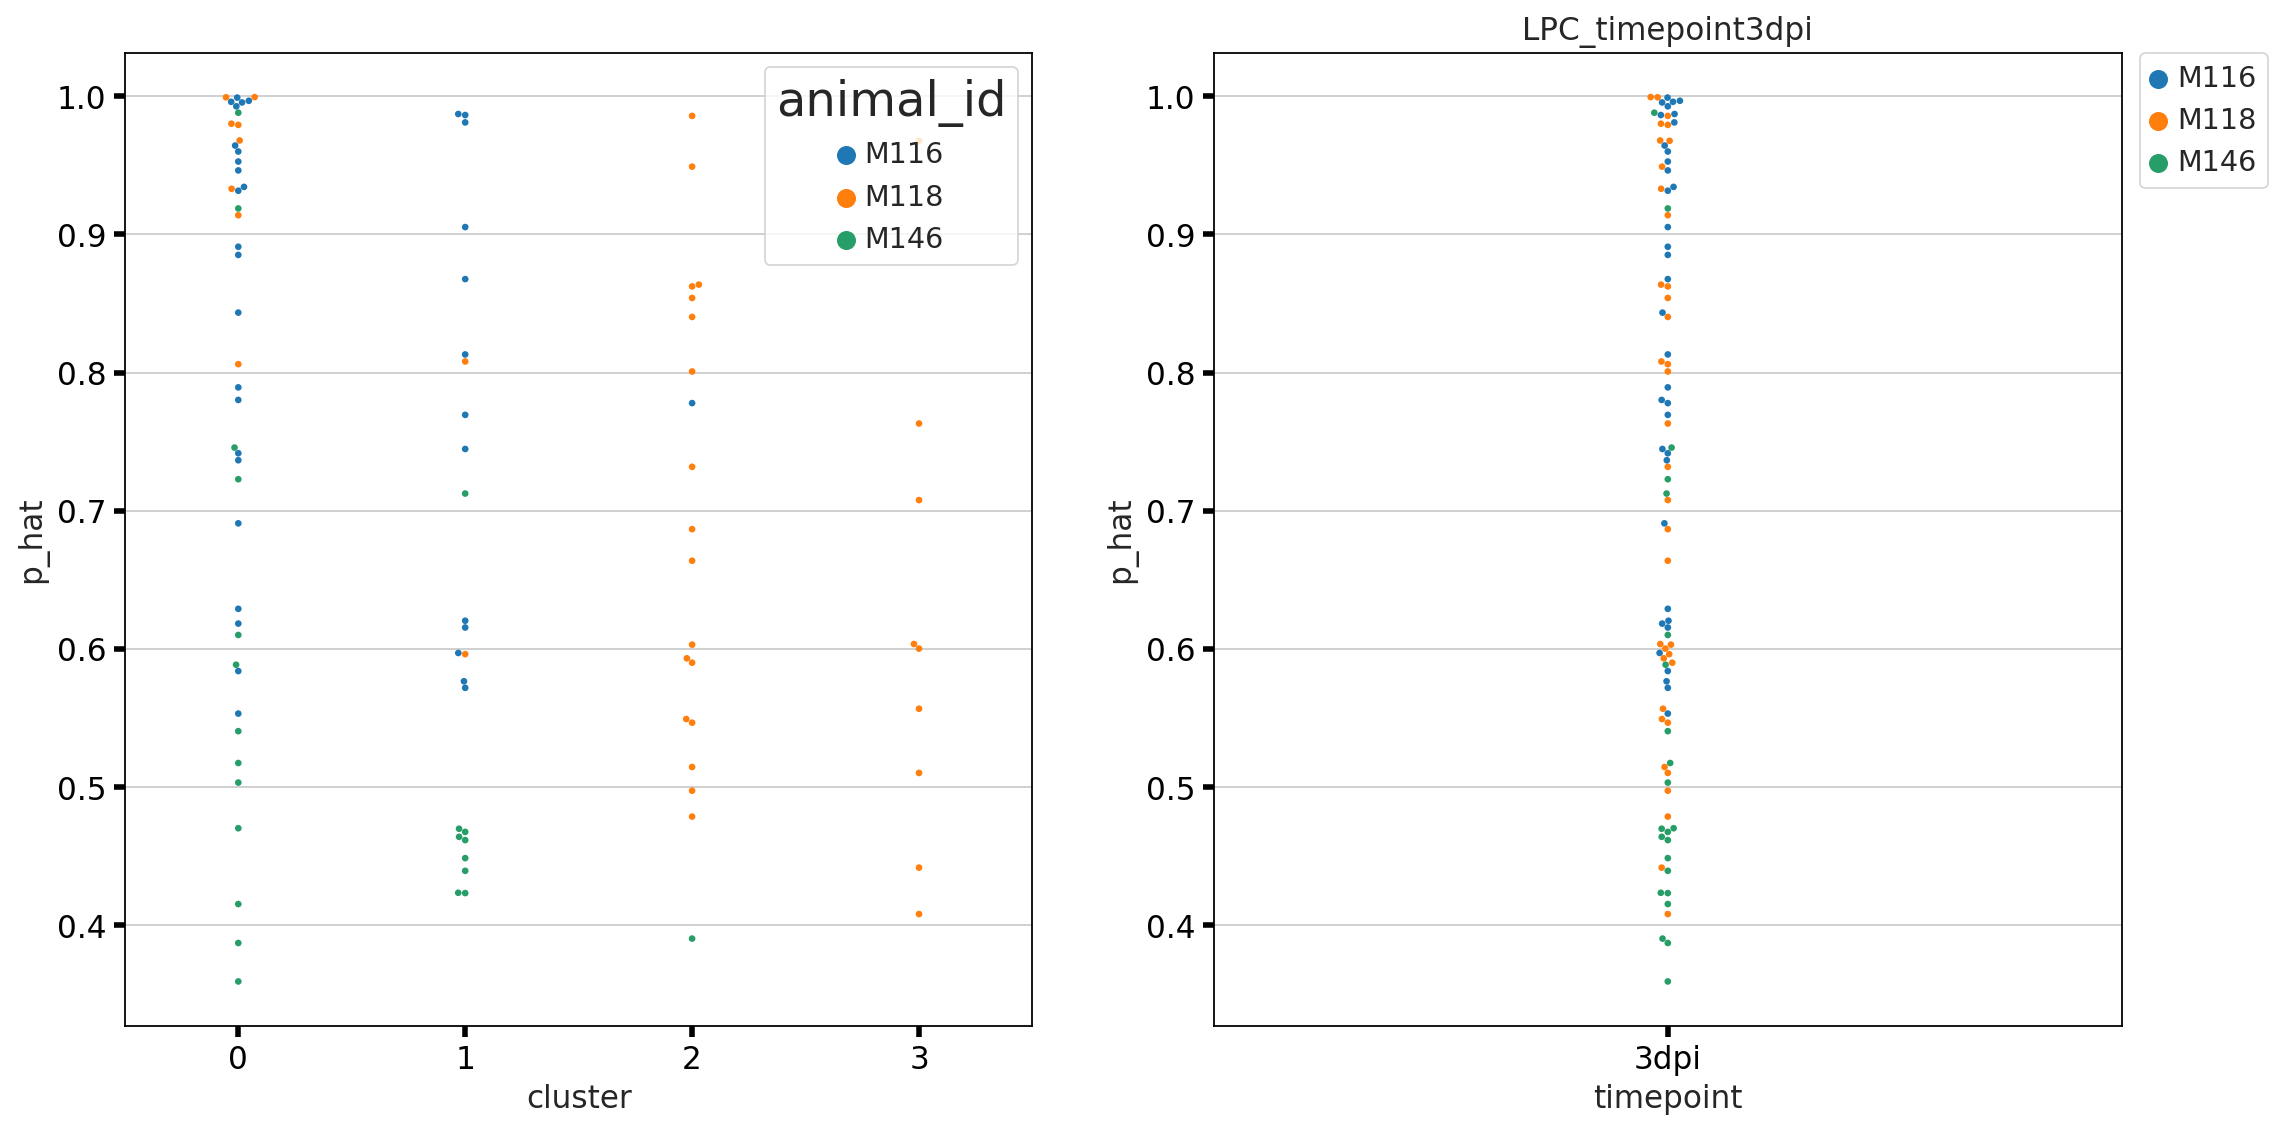

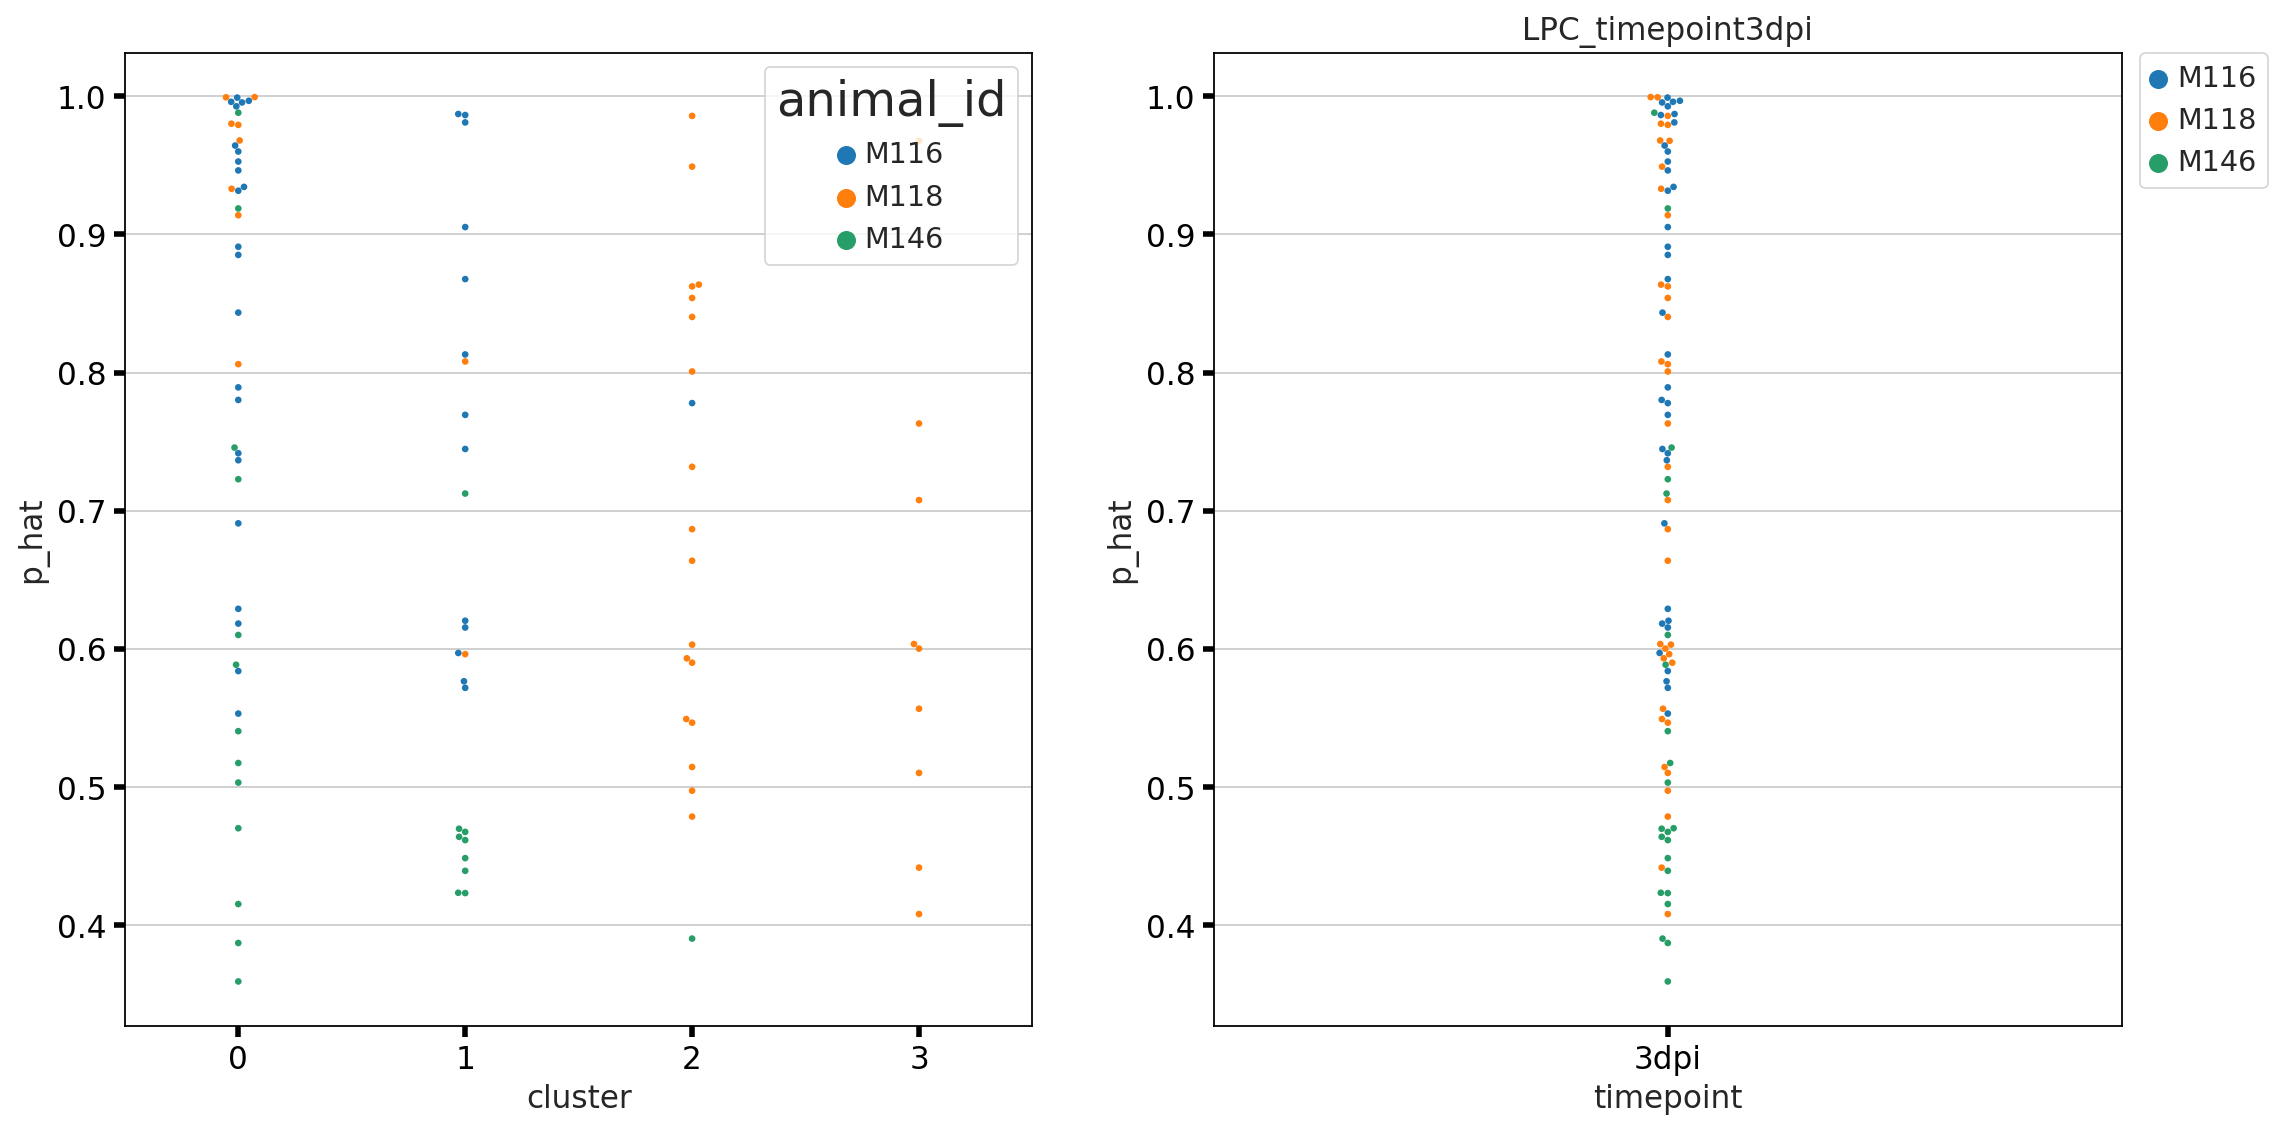

Trying to set attribute `.obs` of view, copying.


animal_id
M116    [1]
M118    [1]
M146    [1]
dtype: object


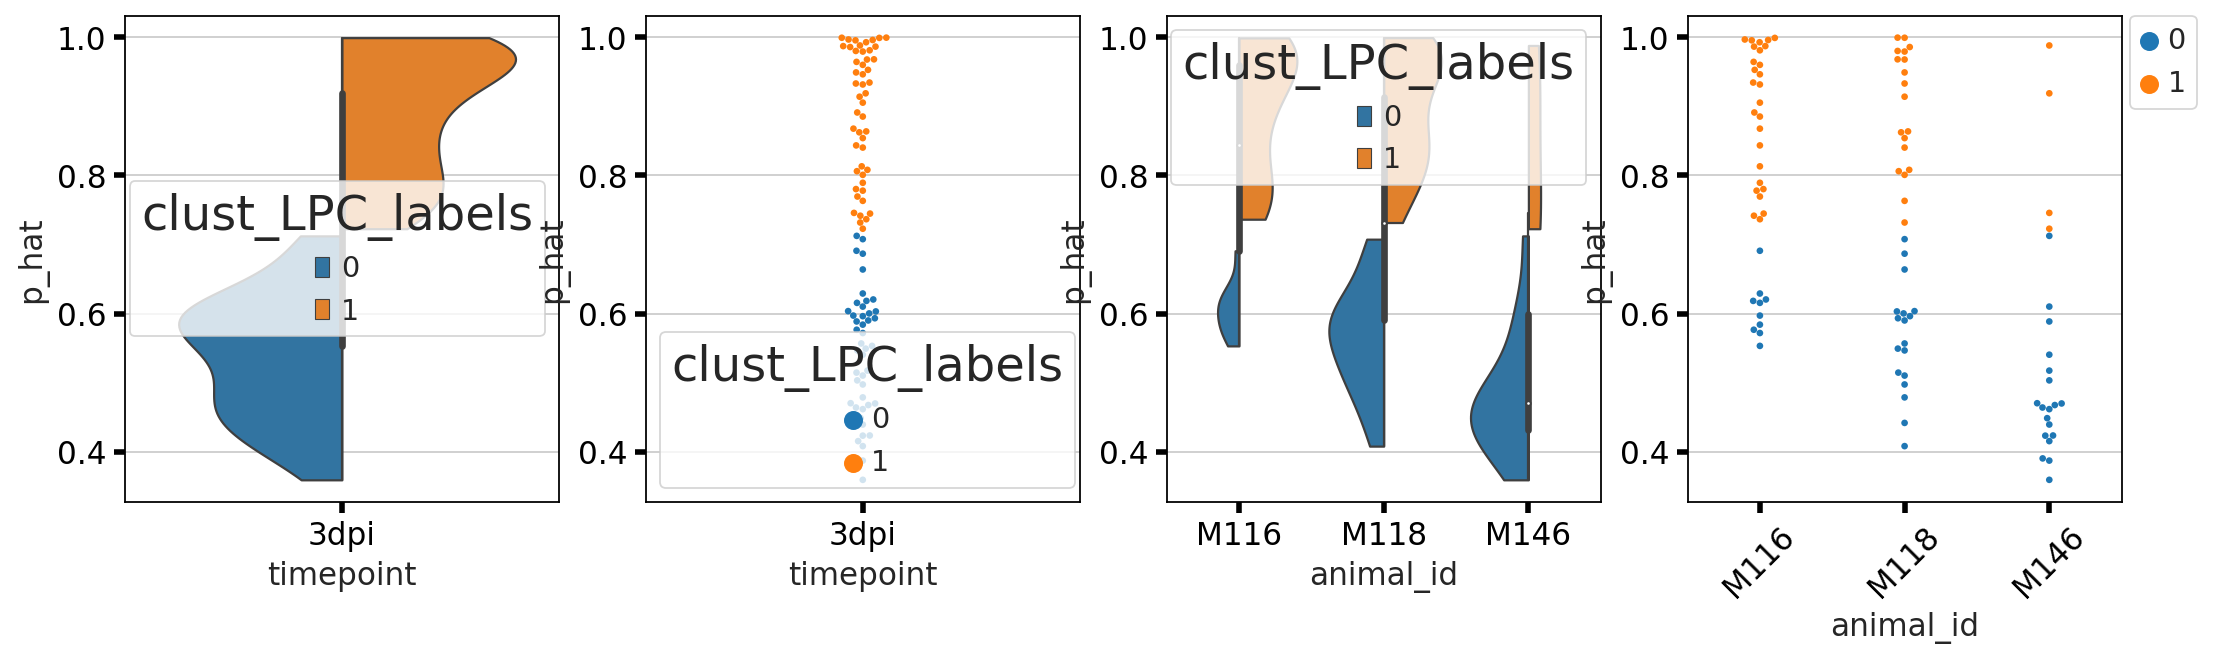

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
#sns.kdeplot(adata_timepoint_condition.obs['p_hat'], fill=True, color=COLOR, alpha=1, ax=ax1)
sns.swarmplot(data=adata_timepoint_condition.obs, x='cluster', y='p_hat', hue='animal_id', size=3, ax=ax1) 
#ax1.set_title(f'dist. of p_hat, {CONDITION_NAME} {CLUSTER}')
#sns.violinplot(data=adata_timepoint_condition.obs, x='timepoint', y='p_hat', hue="animal_id", linewidth=1, scale='count', ax=ax2, palette=['darkorange'])
sns.swarmplot(data=adata_timepoint_condition.obs, x='timepoint', y='p_hat', hue="animal_id", size=3, ax=ax2) 
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax2.set_title(f"{CONDITION_NAME}_timepoint{TIMEPOINT}")
#plt.savefig(f'figures/swarmplots_p_hat_byanimal_timepoint{TIMEPOINT}_condition{CONDITION}_pcs{NUM_PCS}.png')
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
#sns.kdeplot(adata_timepoint_condition.obs['p_hat'], fill=True, color=COLOR, alpha=1, ax=ax1)
sns.swarmplot(data=adata_timepoint_condition.obs, x='cluster', y='p_hat', hue='animal_id', size=3, ax=ax1) 
#ax1.set_title(f'dist. of p_hat, {CONDITION_NAME} {CLUSTER}')
#sns.violinplot(data=adata_timepoint_condition.obs, x='timepoint', y='p_hat', hue="animal_id", linewidth=1, scale='count', ax=ax2, palette=['darkorange'])
sns.swarmplot(data=adata_timepoint_condition.obs, x='timepoint', y='p_hat', hue="animal_id", size=3, ax=ax2) 
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax2.set_title(f"{CONDITION_NAME}_timepoint{TIMEPOINT}")
#plt.savefig(f'figures/swarmplots_p_hat_byanimal_timepoint{TIMEPOINT}_condition{CONDITION}_pcs{NUM_PCS}.png')
plt.show()

print(adata_timepoint_condition.obs.groupby('animal_id').apply(lambda x: x['status'].unique()))

kmeans_condition_dpi = KMeans(n_clusters=2, random_state=0).fit(pd.DataFrame(adata_timepoint_condition.obs['p_hat']))
mean_p_hat_kmeans_label0 = np.mean(adata_timepoint_condition.obs['logit_p_hat'][kmeans_condition_dpi.labels_==0]) 
mean_p_hat_kmeans_label1 = np.mean(adata_timepoint_condition.obs['logit_p_hat'][kmeans_condition_dpi.labels_==1])
zero_lab_has_lower_mean = mean_p_hat_kmeans_label0 < mean_p_hat_kmeans_label1
adata_timepoint_condition.obs[f'clust_{CONDITION_NAME}_labels'] = [1 if x==int(zero_lab_has_lower_mean) else 0 for x in kmeans_condition_dpi.labels_]

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
sns.violinplot(data=adata_timepoint_condition.obs, x='timepoint', y='p_hat', 
               hue=f'clust_{CONDITION_NAME}_labels', split=True, linewidth=1, scale='count', cut=0, ax=ax1)
sns.swarmplot(data=adata_timepoint_condition.obs, x='timepoint', y='p_hat', 
               hue=f'clust_{CONDITION_NAME}_labels', size=3, ax=ax2) 
#ax1.set_title('dist. of p_hat, PBS 3dpi')
sns.violinplot(data=adata_timepoint_condition.obs, x='animal_id', y='p_hat', 
               hue=f'clust_{CONDITION_NAME}_labels', split=True, linewidth=1, scale='count', cut=0, ax=ax3)
sns.swarmplot(data=adata_timepoint_condition.obs, x='animal_id', y='p_hat', 
               hue=f'clust_{CONDITION_NAME}_labels', size=3, ax=ax4)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#plt.savefig(f'figures/swarmplots_p_hat_newlabels_bytimepoint_byanimal_clust_timepoint{TIMEPOINT}_condition{CONDITION}_pcs{NUM_PCS}.png')
plt.show()

Trying to set attribute `.obs` of view, copying.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


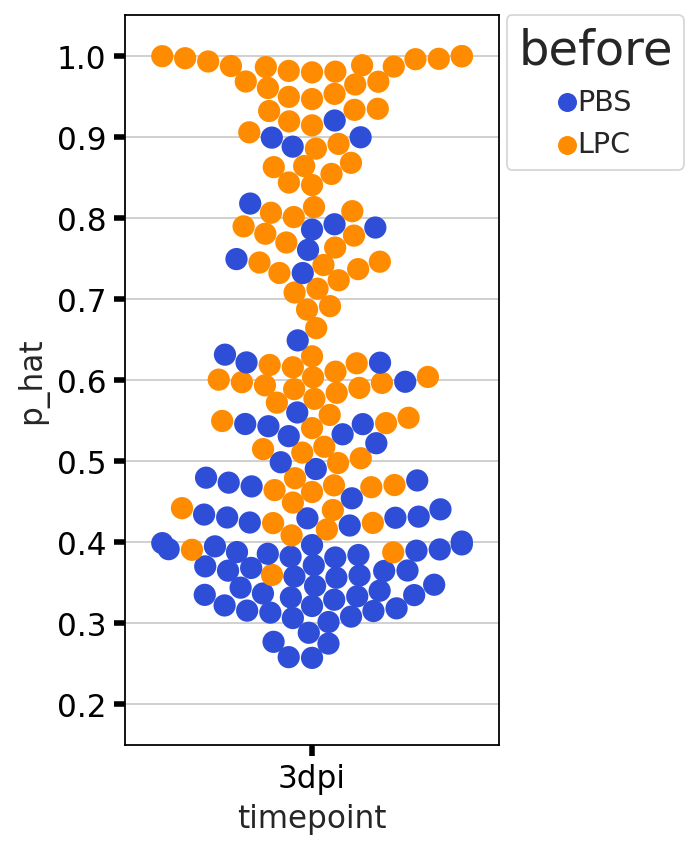

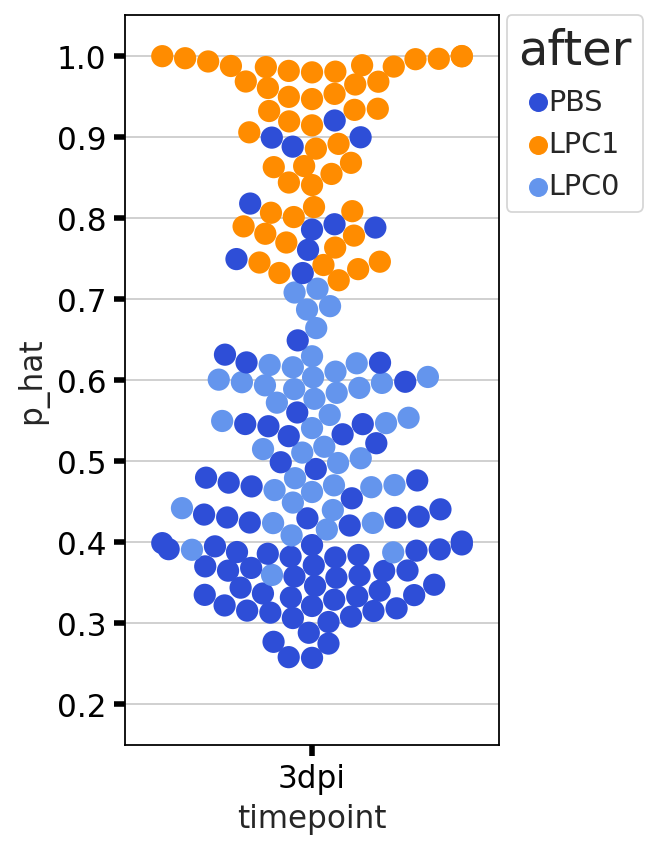

In [40]:
adata_timepoint.obs['new_labels'] = '0'
adata_timepoint.obs['new_labels'][adata_timepoint.obs['status']=='1'] = adata_timepoint_condition.obs['clust_LPC_labels'].astype('str')

conditions = [
    (adata_timepoint.obs['status']=='0'),
    (adata_timepoint.obs['status']=='1') & (adata_timepoint.obs['new_labels']=='0'),
    (adata_timepoint.obs['status']=='1') & (adata_timepoint.obs['new_labels']=='1')
]
values = ['PBS', 'LPC0', 'LPC1']
adata_timepoint.obs['three_labels'] = np.select(conditions, values)


df = sc.get.obs_df(adata_timepoint, ['p_hat', 'logit_p_hat', 'new_labels', 'status', 'three_labels', 'timepoint'])
df.columns = ['p_hat', 'logit_p_hat', 'new_labels', 'status', 'three_labels', 'timepoint']
df['original_labels'] = df['status'].apply(lambda x: 'PBS' if x=='0' else 'LPC')

plt.figure(figsize=(3, 6))
sns.swarmplot(data=df, x='timepoint', y='p_hat', hue="original_labels", size=10, palette=['#2E4ED7', 'darkorange'])
plt.ylim(0.15, 1.05)
#plt.title(f"{subset_title_str}")
plt.legend(title = 'before', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, handletextpad=0.1)
plt.savefig(f'figures/swarmplot_p_hat_status_pcs{NUM_PCS}_{TIMEPOINT}_{CASE_COND}_{subset_title_str}.png', dpi=300, bbox_inches='tight')
plt.savefig(f'figures/swarmplot_p_hat_status_pcs{NUM_PCS}_{TIMEPOINT}_{CASE_COND}_{subset_title_str}.svg', bbox_inches='tight')
plt.savefig(f'figures/swarmplot_p_hat_status_pcs{NUM_PCS}_{TIMEPOINT}_{CASE_COND}_{subset_title_str}.pdf', bbox_inches='tight')
plt.show()


df = sc.get.obs_df(adata_timepoint, ['p_hat', 'logit_p_hat', 'new_labels', 'status', 'three_labels', 'timepoint'])
df.columns = ['p_hat', 'logit_p_hat', 'new_labels', 'status', 'three_labels', 'timepoint']

plt.figure(figsize=(3, 6))
sns.swarmplot(data=df, x='timepoint', y='p_hat', hue="three_labels", size=10, palette=['#2E4ED7', 'darkorange', 'cornflowerblue'])
plt.ylim(0.15, 1.05)
#plt.title(f"{subset_title_str}")
plt.legend(title = 'after', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, handletextpad=0.1)
plt.savefig(f'figures/swarmplot_p_hat_three_labels_pcs{NUM_PCS}_{TIMEPOINT}_{CASE_COND}_{subset_title_str}.png', dpi=300, bbox_inches='tight')
plt.savefig(f'figures/swarmplot_p_hat_three_labels_pcs{NUM_PCS}_{TIMEPOINT}_{CASE_COND}_{subset_title_str}.svg', bbox_inches='tight')
plt.savefig(f'figures/swarmplot_p_hat_three_labels_pcs{NUM_PCS}_{TIMEPOINT}_{CASE_COND}_{subset_title_str}.pdf', bbox_inches='tight')
plt.show()


## Get DEs at this timepoint between PBS and LPC (i.e. using original labels)

In [41]:
adata_timepoint.obs['status'] = adata_timepoint.obs['status'].astype('str')
sc.tl.rank_genes_groups(adata_timepoint, 'status', method='wilcoxon')
#sc.pl.rank_genes_groups(adata_timepoint, n_genes=25, sharey=False)
result = adata_timepoint.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

result_0_df = result_df[['0_n', '0_p', '0_l']]
result_1_df = result_df[['1_n', '1_p', '1_l']]
DEs_0_timepoint = result_0_df.loc[result_0_df['0_p']<0.05].loc[result_0_df['0_l']>0]['0_n'].values
DEs_1_timepoint = result_1_df.loc[result_1_df['1_p']<0.05].loc[result_1_df['1_l']>0]['1_n'].values
print(DEs_0_timepoint.shape, DEs_1_timepoint.shape, result_df.shape)

print(DEs_0_timepoint)
print(DEs_1_timepoint)

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'status' as categorical
/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'new_labels' as categorical
/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always re

(5,) (14,) (16868, 6)
['Ly6c1' 'Cxcl12' 'Pltp' 'Ndrg1' 'Nfkbia']
['Spp1' 'Lyz2' 'Ctsd' 'Fabp5' 'Rock2' 'Tmem252' 'Lgals3' 'Igfbp7' 'Swap70'
 'Ctss' 'Fbxo11' 'Fabp7' 'Fryl' 'Magi1']


## Get DE genes between condition subclusters at this timepoint

In [42]:
adata_timepoint_condition.obs[f'clust_{CONDITION_NAME}_labels'] = adata_timepoint_condition.obs[f'clust_{CONDITION_NAME}_labels'].astype('str')
sc.tl.rank_genes_groups(adata_timepoint_condition, f'clust_{CONDITION_NAME}_labels', method='wilcoxon')
#sc.pl.rank_genes_groups(adata_timepoint_condition, n_genes=25, sharey=False)
result = adata_timepoint_condition.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

result_0_df = result_df[['0_n', '0_p', '0_l']]
result_1_df = result_df[['1_n', '1_p', '1_l']]
DEs_0_timepoint_condition = result_0_df.loc[result_0_df['0_p']<0.05].loc[result_0_df['0_l']>0]['0_n'].values
DEs_1_timepoint_condition = result_1_df.loc[result_1_df['1_p']<0.05].loc[result_1_df['1_l']>0]['1_n'].values
print(DEs_0_timepoint_condition.shape, DEs_1_timepoint_condition.shape, result_df.shape)

print(DEs_0_timepoint_condition)
print(DEs_1_timepoint_condition)

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'status' as categorical
/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'clust_LPC_labels' as categorical


(14,) (13,) (16868, 6)
['Atp10a' 'Igf1r' 'Abcc4' 'Flt1' 'Plcb1' 'Sgms1' 'Ccdc141' 'Sepp1' 'Grasp'
 'Mcf2l' 'Paqr5' 'Slco1a4' 'Pltp' 'Nostrin']
['Vim' 'Anxa2' 'Itgb1' 'Rps14' 'S100a6' 'Msn' 'Lama4' 'Lgals1' 'Fkbp1a'
 'Rpsa' 'Auts2' 'Clic1' 'Pde4d']


## DE using my new labels in 3dpi

In [43]:
adata_timepoint.obs['new_labels'] = '0'
adata_timepoint.obs['new_labels'][adata_timepoint.obs['status']=='1'] = adata_timepoint_condition.obs['clust_LPC_labels']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [44]:
adata_timepoint.obs[f'new_labels'] = adata_timepoint.obs[f'new_labels'].astype('str')
sc.tl.rank_genes_groups(adata_timepoint, f'new_labels', method='wilcoxon')
#sc.pl.rank_genes_groups(adata_timepoint, n_genes=25, sharey=False)
result = adata_timepoint.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

result_0_df = result_df[['0_n', '0_p', '0_l']]
result_1_df = result_df[['1_n', '1_p', '1_l']]
DEs_0_timepoint_new_labels = result_0_df.loc[result_0_df['0_p']<0.05].loc[result_0_df['0_l']>0]['0_n'].values
DEs_1_timepoint_new_labels = result_1_df.loc[result_1_df['1_p']<0.05].loc[result_1_df['1_l']>0]['1_n'].values
print(DEs_0_timepoint_new_labels.shape, DEs_1_timepoint_new_labels.shape, result_df.shape)

print(DEs_0_timepoint_new_labels)
print(DEs_1_timepoint_new_labels)

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'new_labels' as categorical


(21,) (37,) (16868, 6)
['Atp10a' 'Igf1r' 'Pltp' 'Flt1' 'Ndrg1' 'Sgms1' 'Plcb1' 'Ly6c1' 'Tmtc2'
 'Itm2a' 'Slco1a4' 'Ccny' 'Abcc4' 'Nostrin' 'Cxcl12' 'Paqr5' 'Ccdc141'
 'Tsc22d1' 'Nfkbia' 'Tbc1d4' 'Spock2']
['Vim' 'Spp1' 'Lgals1' 'Anxa2' 'S100a6' 'Ctsd' 'Rpsa' 'Tmem252' 'Nid1'
 'Litaf' 'Ubtd1' 'Plec' 'Fkbp1a' 'Fabp5' 'Fyn' 'Cd9' 'Msn' 'Fmnl2'
 'Adamts9' 'Ankrd17' 'Rock2' 'Hif1a' 'Fabp7' 'Rplp0' 'Itgb1' 'Tmsb10'
 'Lyz2' 'Crlf2' 'Auts2' 'Suco' 'Lgals3' 'Sparc' 'Smad1' 'Cdh13' 'Rapgef5'
 'Col4a1' 'Igfbp7']


In [45]:
#result_1_df.loc[result_1_df['1_n'].isin(['Ikbkb', 'Irf2', 'Irf3', 'Stat3', 'Mfsd2a', 'Cul1', 'Herc1'])]

## Save new labels for ligand-receptor interaction analysis

In [49]:
adata_timepoint.obs[['barcodes', 'new_labels']].to_csv('latent_space_structure/data/cellphonedb/endos3dpi_newlabels.csv')

## Unique markers

In [46]:
print('np.intersect1d(DEs_0_timepoint_new_labels, DEs_0_timepoint)')
print(len(np.intersect1d(DEs_0_timepoint_new_labels, DEs_0_timepoint)))
print(np.intersect1d(DEs_0_timepoint_new_labels, DEs_0_timepoint))

print('np.setdiff1d(DEs_0_timepoint, DEs_0_timepoint_new_labels)')
print(len(np.setdiff1d(DEs_0_timepoint, DEs_0_timepoint_new_labels)))
print(np.setdiff1d(DEs_0_timepoint, DEs_0_timepoint_new_labels))

print('np.setdiff1d(DEs_0_timepoint_new_labels, DEs_0_timepoint)')
print(len(np.setdiff1d(DEs_0_timepoint_new_labels, DEs_0_timepoint)))
print(np.setdiff1d(DEs_0_timepoint_new_labels, DEs_0_timepoint))

np.intersect1d(DEs_0_timepoint_new_labels, DEs_0_timepoint)
5
['Cxcl12' 'Ly6c1' 'Ndrg1' 'Nfkbia' 'Pltp']
np.setdiff1d(DEs_0_timepoint, DEs_0_timepoint_new_labels)
0
[]
np.setdiff1d(DEs_0_timepoint_new_labels, DEs_0_timepoint)
16
['Abcc4' 'Atp10a' 'Ccdc141' 'Ccny' 'Flt1' 'Igf1r' 'Itm2a' 'Nostrin'
 'Paqr5' 'Plcb1' 'Sgms1' 'Slco1a4' 'Spock2' 'Tbc1d4' 'Tmtc2' 'Tsc22d1']


In [47]:
print('np.intersect1d(DEs_1_timepoint_new_labels, DEs_1_timepoint)')
print(len(np.intersect1d(DEs_1_timepoint_new_labels, DEs_1_timepoint)))
print(np.intersect1d(DEs_1_timepoint_new_labels, DEs_1_timepoint))

print('np.setdiff1d(DEs_1_timepoint, DEs_1_timepoint_new_labels)')
print(len(np.setdiff1d(DEs_1_timepoint, DEs_1_timepoint_new_labels)))
print(np.setdiff1d(DEs_1_timepoint, DEs_1_timepoint_new_labels))

print('np.setdiff1d(DEs_1_timepoint_new_labels, DEs_1_timepoint)')
print(len(np.setdiff1d(DEs_1_timepoint_new_labels, DEs_1_timepoint)))
print(np.setdiff1d(DEs_1_timepoint_new_labels, DEs_1_timepoint))

np.intersect1d(DEs_1_timepoint_new_labels, DEs_1_timepoint)
9
['Ctsd' 'Fabp5' 'Fabp7' 'Igfbp7' 'Lgals3' 'Lyz2' 'Rock2' 'Spp1' 'Tmem252']
np.setdiff1d(DEs_1_timepoint, DEs_1_timepoint_new_labels)
5
['Ctss' 'Fbxo11' 'Fryl' 'Magi1' 'Swap70']
np.setdiff1d(DEs_1_timepoint_new_labels, DEs_1_timepoint)
28
['Adamts9' 'Ankrd17' 'Anxa2' 'Auts2' 'Cd9' 'Cdh13' 'Col4a1' 'Crlf2'
 'Fkbp1a' 'Fmnl2' 'Fyn' 'Hif1a' 'Itgb1' 'Lgals1' 'Litaf' 'Msn' 'Nid1'
 'Plec' 'Rapgef5' 'Rplp0' 'Rpsa' 'S100a6' 'Smad1' 'Sparc' 'Suco' 'Tmsb10'
 'Ubtd1' 'Vim']


## DE at 3dpi of PBS vs LPC0

In [48]:
conditions = [
    (adata_timepoint.obs['status']=='0'),
    (adata_timepoint.obs['status']=='1') & (adata_timepoint.obs['new_labels']=='0'),
    (adata_timepoint.obs['status']=='1') & (adata_timepoint.obs['new_labels']=='1')
]
values = ['PBS', 'LPC_0', 'LPC_1']
adata_timepoint.obs['three_labels'] = np.select(conditions, values)

In [49]:
adata_timepoint_newlabel0 = adata_timepoint[adata_timepoint.obs['three_labels'].isin(['PBS', 'LPC_0'])]

adata_timepoint_newlabel0.obs[f'three_labels'] = adata_timepoint_newlabel0.obs[f'three_labels'].astype('str')
sc.tl.rank_genes_groups(adata_timepoint_newlabel0, f'three_labels', method='wilcoxon')
#sc.pl.rank_genes_groups(adata_timepoint_newlabel0, n_genes=25, sharey=False)
result = adata_timepoint_newlabel0.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

result_PBS_df = result_df[['PBS_n', 'PBS_p', 'PBS_l']]
result_LPC0_df = result_df[['LPC_0_n', 'LPC_0_p', 'LPC_0_l']]
DEs_PBS_timepoint_newlabel0 = result_PBS_df.loc[result_PBS_df['PBS_p']<0.05].loc[result_PBS_df['PBS_l']>0]['PBS_n'].values
DEs_LPC0_timepoint_newlabel0 = result_LPC0_df.loc[result_LPC0_df['LPC_0_p']<0.05].loc[result_LPC0_df['LPC_0_l']>0]['LPC_0_n'].values
print(DEs_PBS_timepoint_newlabel0.shape, DEs_LPC0_timepoint_newlabel0.shape, result_df.shape)

print(DEs_PBS_timepoint_newlabel0)
print(DEs_LPC0_timepoint_newlabel0)

Trying to set attribute `.obs` of view, copying.
/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'three_labels' as categorical


(0,) (4,) (16868, 6)
[]
['Spp1' 'Lyz2' 'Ctsd' 'Fabp5']


## DE at 3dpi of LPC0 vs LPC1

In [84]:
adata_timepoint_LPC = adata_timepoint[adata_timepoint.obs['three_labels'].isin(['LPC_0', 'LPC_1'])]

adata_timepoint_LPC.obs[f'three_labels'] = adata_timepoint_LPC.obs[f'three_labels'].astype('str')
sc.tl.rank_genes_groups(adata_timepoint_LPC, f'three_labels', method='wilcoxon')
#sc.pl.rank_genes_groups(adata_timepoint_LPC, n_genes=25, sharey=False)
result = adata_timepoint_LPC.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

result_LPC0_df = result_df[['LPC_0_n', 'LPC_0_p', 'LPC_0_l']]
result_LPC1_df = result_df[['LPC_1_n', 'LPC_1_p', 'LPC_1_l']]
DEs_LPC0_timepoint_LPC = result_LPC0_df.loc[result_LPC0_df['LPC_0_p']<0.05].loc[result_LPC0_df['LPC_0_l']>0]['LPC_0_n'].values
DEs_LPC1_timepoint_LPC = result_LPC1_df.loc[result_LPC1_df['LPC_1_p']<0.05].loc[result_LPC1_df['LPC_1_l']>0]['LPC_1_n'].values
print(DEs_LPC0_timepoint_LPC.shape, DEs_LPC1_timepoint_LPC.shape, result_df.shape)

print(DEs_LPC0_timepoint_LPC)
print(DEs_LPC1_timepoint_LPC)

Trying to set attribute `.obs` of view, copying.
/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'three_labels' as categorical


(14,) (13,) (16868, 6)
['Atp10a' 'Igf1r' 'Abcc4' 'Flt1' 'Plcb1' 'Sgms1' 'Ccdc141' 'Sepp1' 'Grasp'
 'Mcf2l' 'Paqr5' 'Slco1a4' 'Pltp' 'Nostrin']
['Vim' 'Anxa2' 'Itgb1' 'Rps14' 'S100a6' 'Msn' 'Lama4' 'Lgals1' 'Fkbp1a'
 'Rpsa' 'Auts2' 'Clic1' 'Pde4d']


In [97]:
result_LPC1_df.loc[result_LPC1_df['LPC_1_p']<0.05].loc[result_LPC1_df['LPC_1_l']>0][['LPC_1_n', 'LPC_1_p']]

LPC_1_n   LPC_1_p
0      Vim  0.000049
1    Anxa2  0.003018
2    Itgb1  0.019214
3    Rps14  0.019214
4   S100a6  0.020557
5      Msn  0.024357
6    Lama4  0.027573
7   Lgals1  0.027999
8   Fkbp1a  0.036159
9     Rpsa  0.043281
10   Auts2  0.044517
11   Clic1  0.046254
12   Pde4d  0.046254

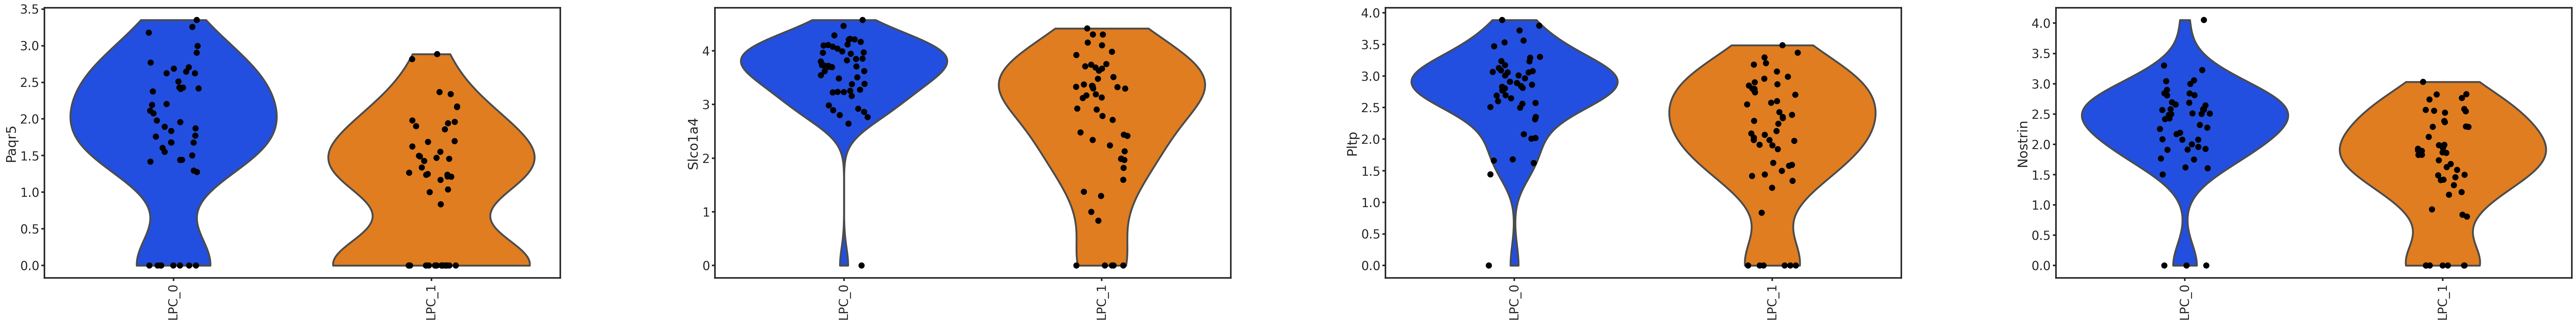

In [100]:
# violin plots with p-values
sc.pl.violin(adata_timepoint_LPC, DEs_LPC0_timepoint_LPC[10:14], groupby='three_labels', 
             size=10, rotation=90, save=f'_LPC0_vsLP1_DEsLPC0_third.png')
#sc.pl.violin(adata, DEs_1, groupby='timepoint', rotation=90)

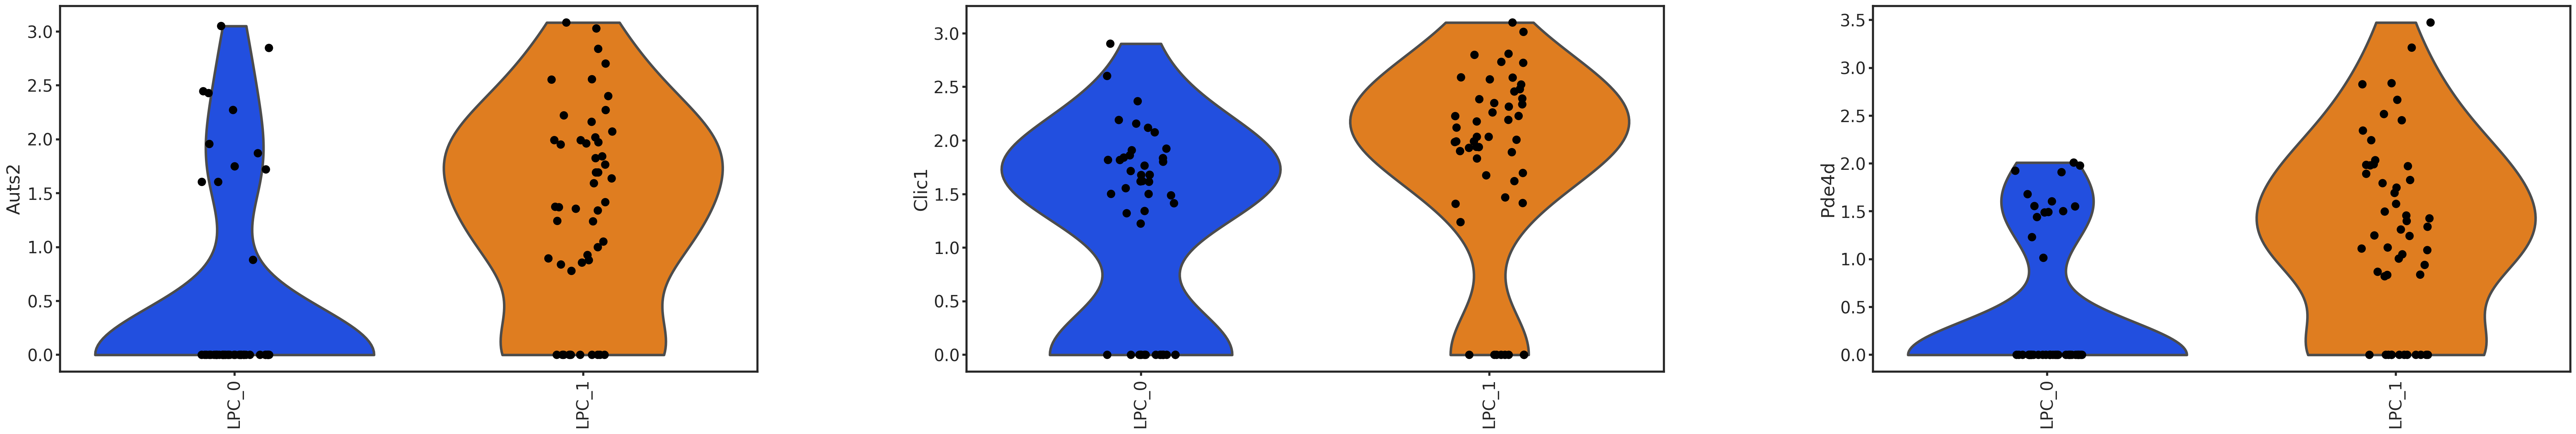

In [104]:
sc.pl.violin(adata_timepoint_LPC, DEs_LPC1_timepoint_LPC[10:13], groupby='three_labels', 
             size=10, rotation=90, save=f'_LPC0_vsLP1_DEsLPC1_third.png')

## Overlap between cluster labels and three_labels

In [105]:
adata_timepoint

AnnData object with n_obs × n_vars = 181 × 16868
    obs: 'barcodes', 'n_genes', 'percent_mito', 'n_counts', 'status', 'animal_id', 'timepoint', 'cluster', 'leiden', 'p_hat', 'logit_p_hat', 'new_labels', 'three_labels'
    var: 'gene_ids', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'cluster_colors', 'status_colors', 'leiden_colors', 'animal_id_colors', 'timepoint_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


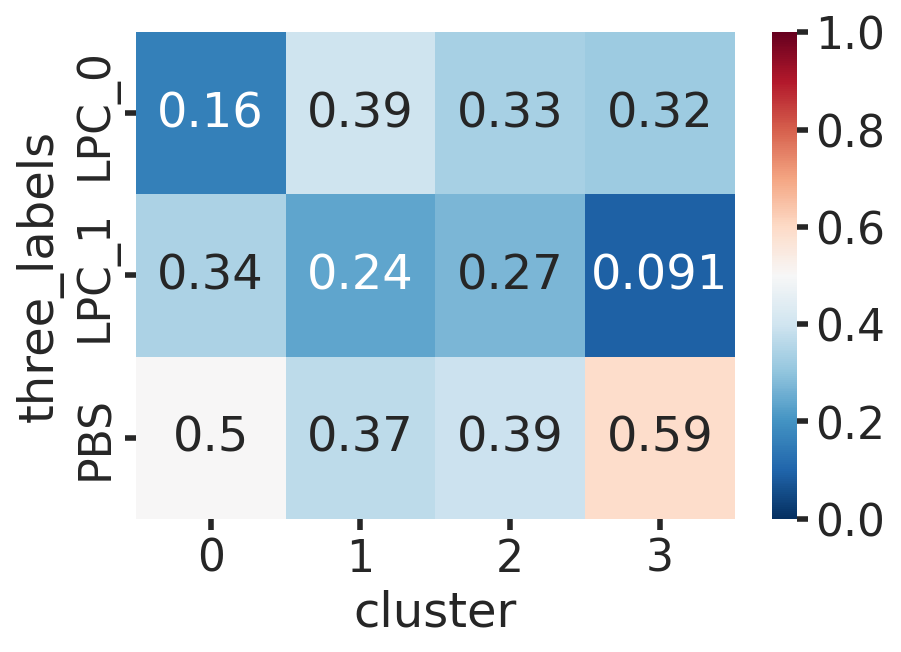

In [106]:
sub_df = adata_timepoint.obs[['cluster', 'three_labels']]
sub_df['count'] = 1

#sub_df['original labels'] = sub_df['status'].apply(lambda x: 'PBS' if x==0 else 'LPC')

g = pd.pivot_table(sub_df, index=['three_labels'], columns='cluster', values='count', aggfunc=np.sum)
g = g.apply(lambda x: x/np.sum(x))
plt.figure(figsize=(6, 4))
sns.heatmap(g, cmap='RdBu_r', annot=True, vmin=0, vmax=1)
#plt.savefig(f'figures/table_cluster_{subset_title_str}.png', dpi=300, bbox_inches='tight')
#plt.savefig(f'figures/table_cluster_{subset_title_str}.svg', bbox_inches='tight')
#plt.savefig(f'figures/table_cluster_{subset_title_str}.pdf', bbox_inches='tight')
plt.show()

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'three_labels' as categorical


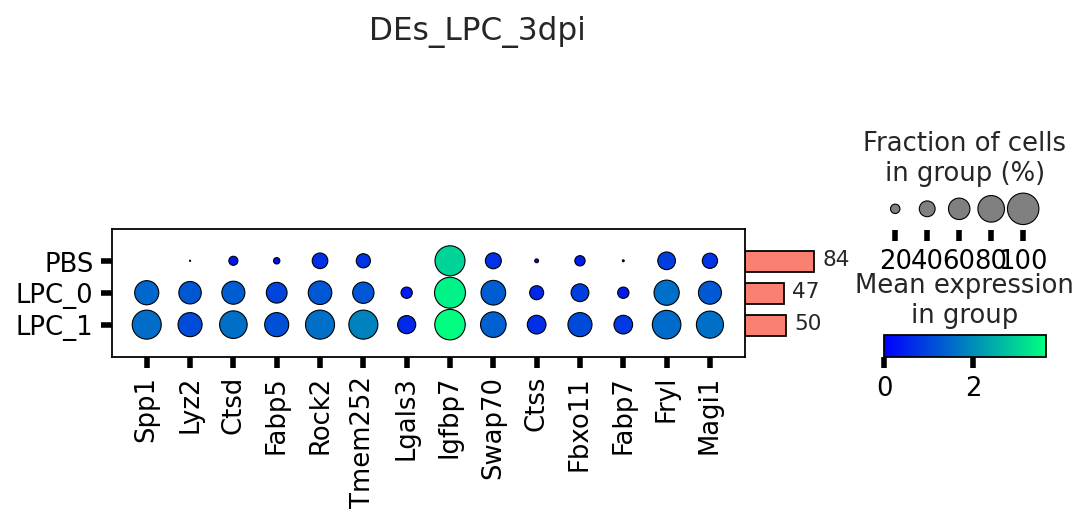

<Figure size 480x480 with 0 Axes>

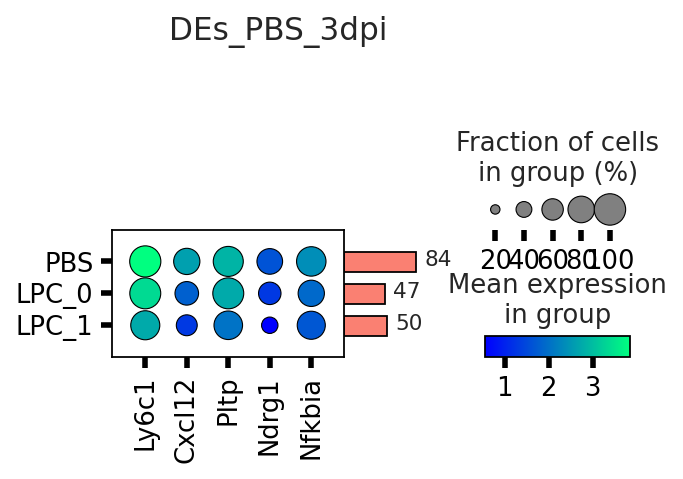

<Figure size 480x480 with 0 Axes>

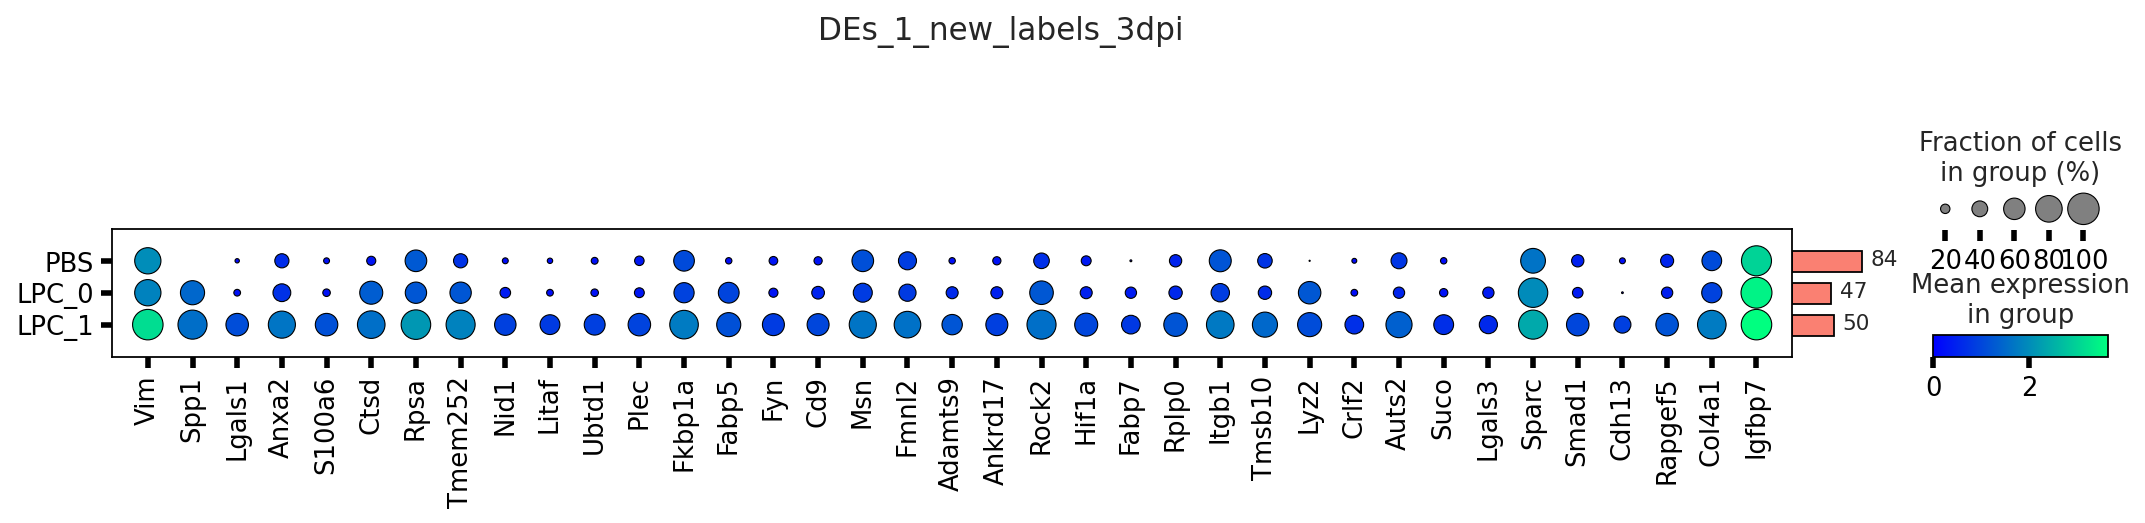

<Figure size 480x480 with 0 Axes>

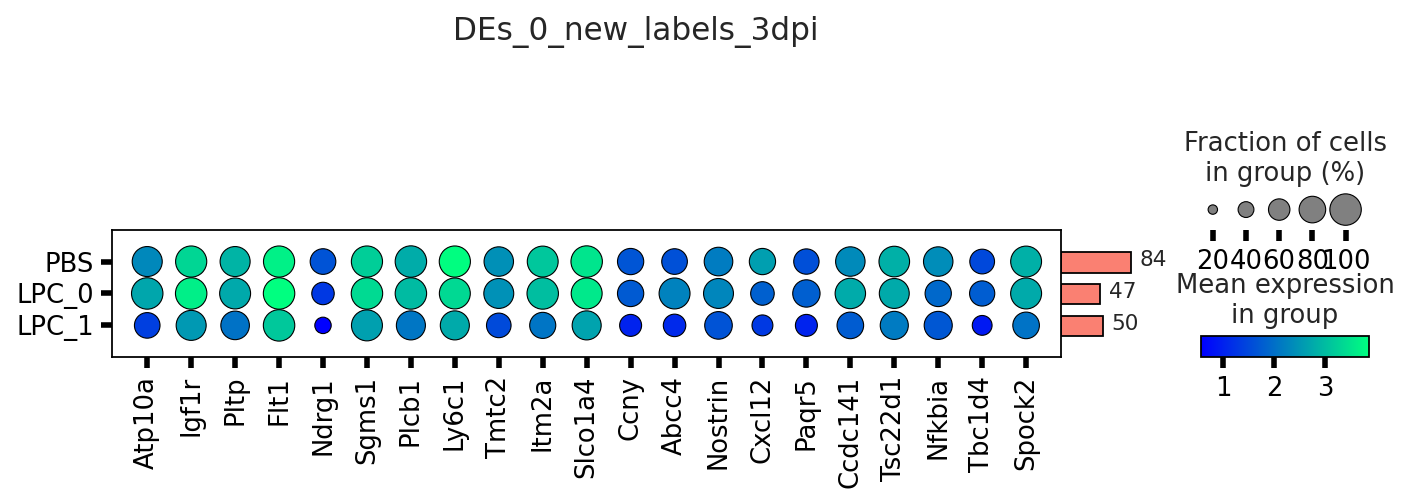

<Figure size 480x480 with 0 Axes>

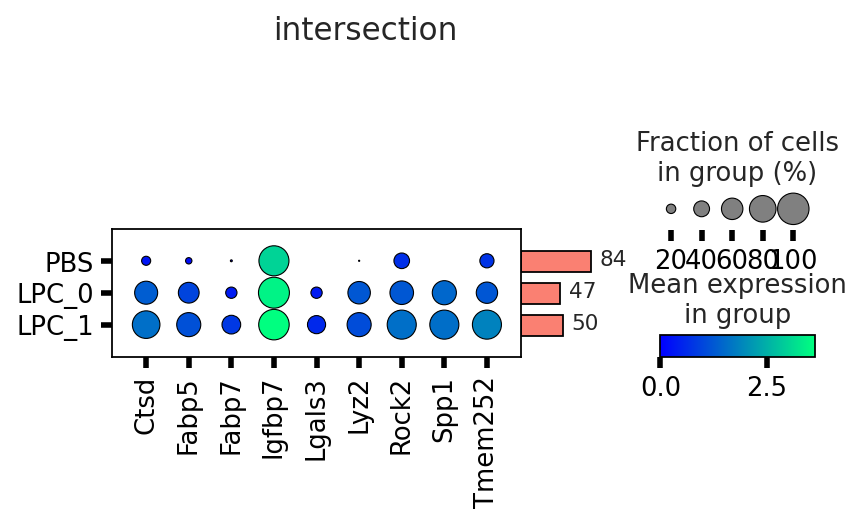

<Figure size 480x480 with 0 Axes>

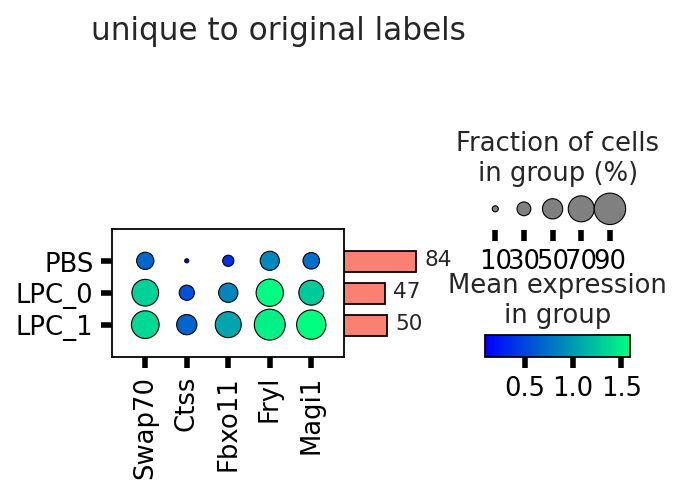

<Figure size 480x480 with 0 Axes>

In [50]:
# just using original labels
dp = sc.pl.dotplot(adata=adata_timepoint, 
                   var_names=DEs_1_timepoint, 
                   groupby=f'three_labels',
                   categories_order=['PBS', 'LPC_0', 'LPC_1'],
                   title=f'DEs_LPC_{TIMEPOINT}',
                   return_fig=True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()
plt.savefig(f'figures/dotplot_three_labels_DEs_LPC_{TIMEPOINT}_pcs{NUM_PCS}.png')


dp = sc.pl.dotplot(adata=adata_timepoint, 
                   var_names=DEs_0_timepoint, 
                   groupby=f'three_labels',
                   categories_order=['PBS', 'LPC_0', 'LPC_1'],
                   title=f'DEs_PBS_{TIMEPOINT}',
                   return_fig=True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()
plt.savefig(f'figures/dotplot_three_labels_DEs_PBS_{TIMEPOINT}_pcs{NUM_PCS}.png')
plt.show()

# just using new_labels
dp = sc.pl.dotplot(adata=adata_timepoint, 
                   var_names=DEs_1_timepoint_new_labels, 
                   groupby=f'three_labels',
                   categories_order=['PBS', 'LPC_0', 'LPC_1'],
                   title=f'DEs_1_new_labels_{TIMEPOINT}',
                   return_fig=True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()
plt.savefig(f'figures/dotplot_three_labels_DEs_1_new_labels_{TIMEPOINT}_pcs{NUM_PCS}.png')
plt.show()

dp = sc.pl.dotplot(adata=adata_timepoint, 
                   var_names=DEs_0_timepoint_new_labels, 
                   groupby=f'three_labels',
                   categories_order=['PBS', 'LPC_0', 'LPC_1'],
                   title=f'DEs_0_new_labels_{TIMEPOINT}',
                   return_fig=True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()
plt.savefig(f'figures/dotplot_three_labels_DEs_0_new_labels_{TIMEPOINT}_pcs{NUM_PCS}.png')
plt.show()

# intersection
dp = sc.pl.dotplot(adata=adata_timepoint, 
                   var_names=np.intersect1d(DEs_1_timepoint_new_labels, DEs_1_timepoint), 
                   groupby=f'three_labels',
                   categories_order=['PBS', 'LPC_0', 'LPC_1'],
                   title='intersection',
                   return_fig=True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()
plt.savefig(f'figures/dotplot_three_labels_DEs_intersection_{TIMEPOINT}_pcs{NUM_PCS}.png')
plt.show()


# unique to original labels
dp = sc.pl.dotplot(adata=adata_timepoint, 
                   var_names=['Swap70', 'Ctss','Fbxo11','Fryl','Magi1'], 
                   groupby=f'three_labels',
                   categories_order=['PBS', 'LPC_0', 'LPC_1'],
                   title='unique to original labels',
                   return_fig=True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()
plt.savefig(f'figures/dotplot_three_labels_DEs_unique_to_original_labels_{TIMEPOINT}_pcs{NUM_PCS}.png')
plt.show()

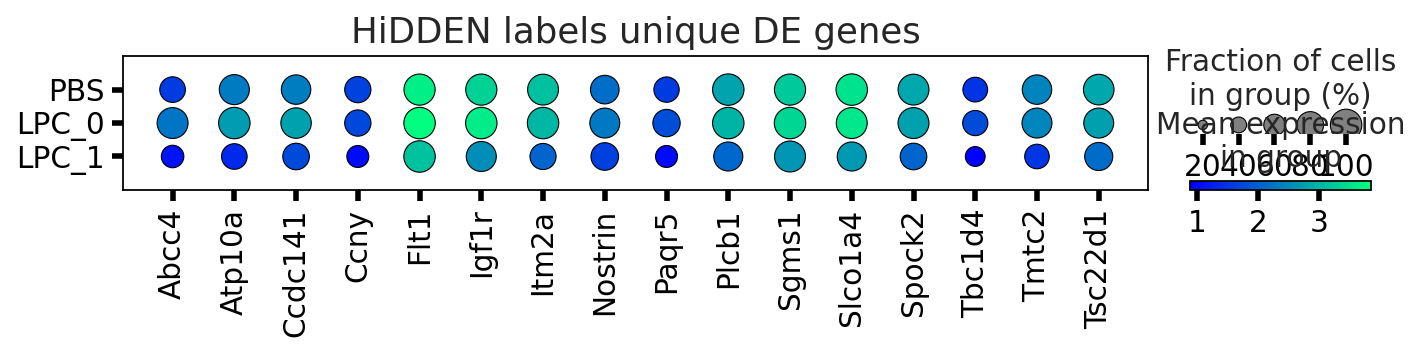

In [51]:
# unique to new_labels 0
sc.set_figure_params(scanpy=True, fontsize=16)
dp = sc.pl.dotplot(adata=adata_timepoint, 
                   use_raw=True,
                   var_names=np.setdiff1d(DEs_0_timepoint_new_labels, DEs_0_timepoint), 
                   groupby=f'three_labels',
                   categories_order=['PBS', 'LPC_0', 'LPC_1'],
                   title='HiDDEN labels unique DE genes',
                   figsize=(10, 1.1), return_fig=True)
#dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).savefig(
#    f'figures/dotplot_three_labels_DEs_unique_to_new_labels_{TIMEPOINT}_pcs{NUM_PCS}.png')
dp.style(dot_edge_color='black', dot_edge_lw=0.5).savefig(
    f'figures/dotplot_three_labels_DEs_unique_to_new_labels_0_{TIMEPOINT}_pcs{NUM_PCS}.png')

#sc.pl.stacked_violin(adata_cluster, DEs_1_cluster_new_labels, groupby=f'three_labels',
#                   categories_order=['PBS', 'LPC_0', 'LPC_1'],
#                   rotation=90)
plt.show()

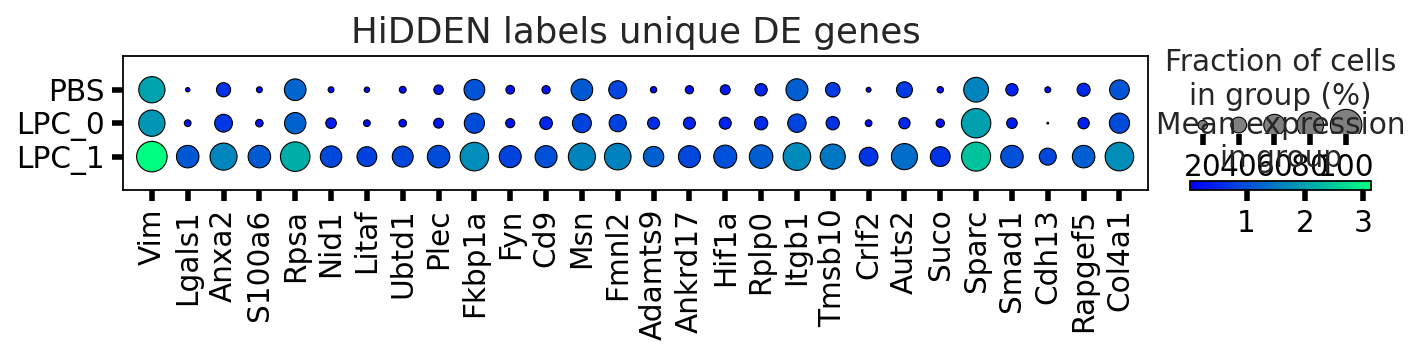

In [52]:
# unique to new_labels 1
sc.set_figure_params(scanpy=True, fontsize=16)
dp = sc.pl.dotplot(adata=adata_timepoint, 
                   use_raw=True,
                   var_names=['Vim','Lgals1','Anxa2','S100a6','Rpsa','Nid1','Litaf','Ubtd1','Plec','Fkbp1a','Fyn','Cd9',
                              'Msn','Fmnl2','Adamts9','Ankrd17','Hif1a','Rplp0','Itgb1','Tmsb10','Crlf2','Auts2','Suco',
                              'Sparc','Smad1','Cdh13','Rapgef5','Col4a1'], 
                   groupby=f'three_labels',
                   categories_order=['PBS', 'LPC_0', 'LPC_1'],
                   title='HiDDEN labels unique DE genes',
                   figsize=(10, 1.1), return_fig=True)
#dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).savefig(
#    f'figures/dotplot_three_labels_DEs_unique_to_new_labels_{TIMEPOINT}_pcs{NUM_PCS}.png')
dp.style(dot_edge_color='black', dot_edge_lw=0.5).savefig(
    f'figures/dotplot_three_labels_DEs_unique_to_new_labels_{TIMEPOINT}_pcs{NUM_PCS}.png')

#sc.pl.stacked_violin(adata_cluster, DEs_1_cluster_new_labels, groupby=f'three_labels',
#                   categories_order=['PBS', 'LPC_0', 'LPC_1'],
#                   rotation=90)
plt.show()

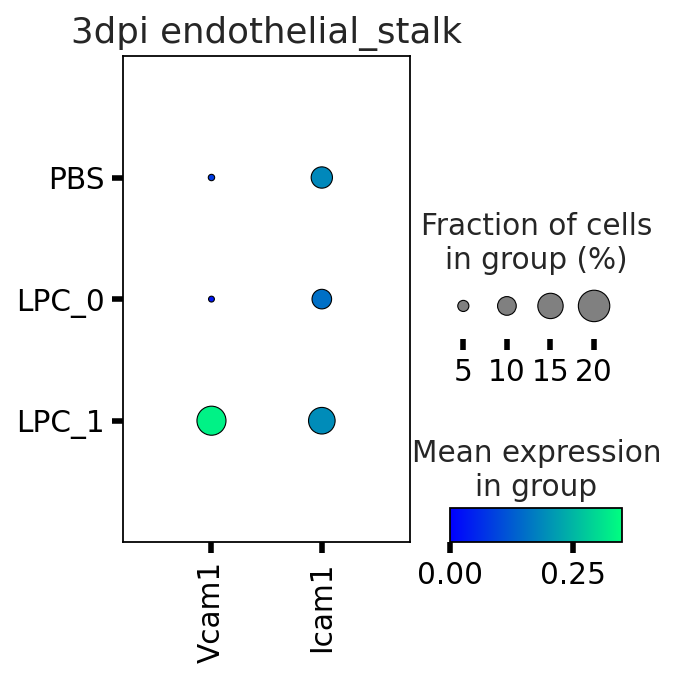

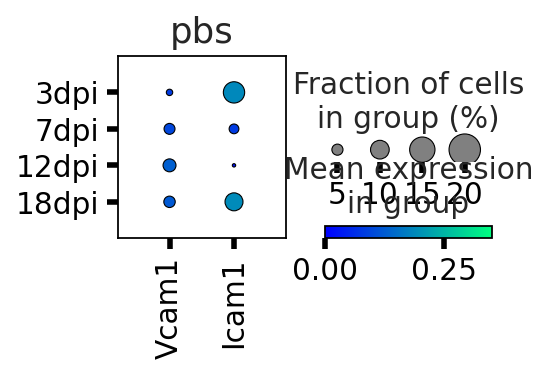

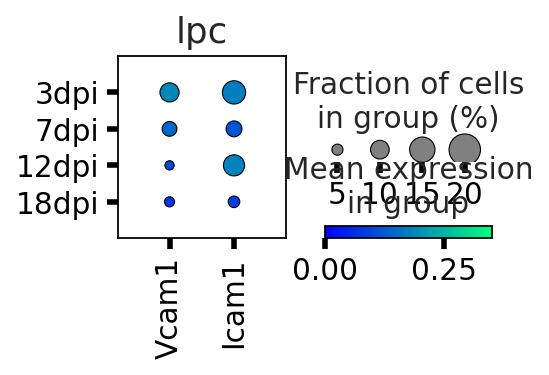

In [74]:
# Figure 5
gene_vec = ['Vcam1', 'Icam1']
# across the three conditions
dp=sc.pl.dotplot(adata=adata_timepoint, 
                var_names=gene_vec, 
                groupby=f'three_labels',
                categories_order=['PBS', 'LPC_0', 'LPC_1'],
                title=f'{TIMEPOINT} {subset_title_str}', 
                dot_min=0, dot_max=0.2, 
                vmin=0, vmax=0.35,
                figsize=(4, 4),
                return_fig=True)
dp.style(dot_edge_color='black', dot_edge_lw=0.5).savefig(
    f'figures/dotplot_Vcam1_threelabels_legend.png')

# across time per PBS / LPC
adata_pbs = adata[adata.obs['status'].isin(['0'])]
adata_lpc = adata[adata.obs['status'].isin(['1'])]

dp=sc.pl.dotplot(adata_pbs, gene_vec, groupby='timepoint', figsize=(3, 1.5), 
                 dot_min=0, dot_max=0.2, vmin=0, vmax=0.35,
                 return_fig=True, title='pbs')
dp.style(dot_edge_color='black', dot_edge_lw=0.5).savefig(
    f'figures/dotplot_Vcam1_pbs_timepoints.png')

dp=sc.pl.dotplot(adata_lpc, gene_vec, groupby='timepoint', figsize=(3, 1.5),
                 dot_min=0, dot_max=0.2, vmin=0, vmax=0.35,
                 return_fig=True, title='lpc')
dp.style(dot_edge_color='black', dot_edge_lw=0.5).savefig(
    f'figures/dotplot_Vcam1_lpc_timepoints.png')

plt.show()